# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: max


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:12:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:12:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:13:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:13:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:13:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:13:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.7984930411134219
Average Accuracy: 0.7379753780734543
Average Precision: 0.6928713510026343
Average Recall: 0.6012989921612542


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:13:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:13:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:13:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:14:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:14:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.7878275361134651
Average Accuracy: 0.7412983093858235
Average Precision: 0.6947144498275432
Average Recall: 0.611959686450168


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))


[0]	validation_0-logloss:0.66596


[1]	validation_0-logloss:0.66303


[2]	validation_0-logloss:0.66139


[3]	validation_0-logloss:0.65840


[4]	validation_0-logloss:0.65551


[5]	validation_0-logloss:0.65320


[6]	validation_0-logloss:0.65109


[7]	validation_0-logloss:0.64863


[8]	validation_0-logloss:0.64624


[9]	validation_0-logloss:0.64407


[10]	validation_0-logloss:0.64124


[11]	validation_0-logloss:0.63886


[12]	validation_0-logloss:0.63662


[13]	validation_0-logloss:0.63444


[14]	validation_0-logloss:0.63204


[15]	validation_0-logloss:0.62977


[16]	validation_0-logloss:0.62739


[17]	validation_0-logloss:0.62542


[18]	validation_0-logloss:0.62373


[19]	validation_0-logloss:0.62153


[20]	validation_0-logloss:0.61965


[21]	validation_0-logloss:0.61766


[22]	validation_0-logloss:0.61567


[23]	validation_0-logloss:0.61409


[24]	validation_0-logloss:0.61280


[25]	validation_0-logloss:0.61140


[26]	validation_0-logloss:0.61043


[27]	validation_0-logloss:0.60914


[28]	validation_0-logloss:0.60752


[29]	validation_0-logloss:0.60596


[30]	validation_0-logloss:0.60441


[31]	validation_0-logloss:0.60283


[32]	validation_0-logloss:0.60109


[33]	validation_0-logloss:0.59947


[34]	validation_0-logloss:0.59777


[35]	validation_0-logloss:0.59616


[36]	validation_0-logloss:0.59475


[37]	validation_0-logloss:0.59347


[38]	validation_0-logloss:0.59184


[39]	validation_0-logloss:0.59081


[40]	validation_0-logloss:0.58883


[41]	validation_0-logloss:0.58733


[42]	validation_0-logloss:0.58564


[43]	validation_0-logloss:0.58413


[44]	validation_0-logloss:0.58292


[45]	validation_0-logloss:0.58147


[46]	validation_0-logloss:0.58057


[47]	validation_0-logloss:0.57963


[48]	validation_0-logloss:0.57842


[49]	validation_0-logloss:0.57701


[50]	validation_0-logloss:0.57597


[51]	validation_0-logloss:0.57448


[52]	validation_0-logloss:0.57314


[53]	validation_0-logloss:0.57198


[54]	validation_0-logloss:0.57094


[55]	validation_0-logloss:0.56940


[56]	validation_0-logloss:0.56823


[57]	validation_0-logloss:0.56696


[58]	validation_0-logloss:0.56574


[59]	validation_0-logloss:0.56495


[60]	validation_0-logloss:0.56368


[61]	validation_0-logloss:0.56237


[62]	validation_0-logloss:0.56127


[63]	validation_0-logloss:0.55995


[64]	validation_0-logloss:0.55885


[65]	validation_0-logloss:0.55779


[66]	validation_0-logloss:0.55666


[67]	validation_0-logloss:0.55580


[68]	validation_0-logloss:0.55471


[69]	validation_0-logloss:0.55376


[70]	validation_0-logloss:0.55295


[71]	validation_0-logloss:0.55220


[72]	validation_0-logloss:0.55159


[73]	validation_0-logloss:0.55078


[74]	validation_0-logloss:0.54987


[75]	validation_0-logloss:0.54898


[76]	validation_0-logloss:0.54835


[77]	validation_0-logloss:0.54707


[78]	validation_0-logloss:0.54628


[79]	validation_0-logloss:0.54587


[80]	validation_0-logloss:0.54481


[81]	validation_0-logloss:0.54437


[82]	validation_0-logloss:0.54381


[83]	validation_0-logloss:0.54322


[84]	validation_0-logloss:0.54208


[85]	validation_0-logloss:0.54143


[86]	validation_0-logloss:0.54105


[87]	validation_0-logloss:0.54071


[88]	validation_0-logloss:0.54003


[89]	validation_0-logloss:0.53916


[90]	validation_0-logloss:0.53816


[91]	validation_0-logloss:0.53729


[92]	validation_0-logloss:0.53639


[93]	validation_0-logloss:0.53584


[94]	validation_0-logloss:0.53518


[95]	validation_0-logloss:0.53457


[96]	validation_0-logloss:0.53395


[97]	validation_0-logloss:0.53335


[98]	validation_0-logloss:0.53246


[99]	validation_0-logloss:0.53155


[100]	validation_0-logloss:0.53129


[101]	validation_0-logloss:0.53079


[102]	validation_0-logloss:0.52994


[103]	validation_0-logloss:0.52919


[104]	validation_0-logloss:0.52899


[105]	validation_0-logloss:0.52804


[106]	validation_0-logloss:0.52771


[107]	validation_0-logloss:0.52702


[108]	validation_0-logloss:0.52630


[109]	validation_0-logloss:0.52579


[110]	validation_0-logloss:0.52584


[111]	validation_0-logloss:0.52492


[112]	validation_0-logloss:0.52442


[113]	validation_0-logloss:0.52401


[114]	validation_0-logloss:0.52360


[115]	validation_0-logloss:0.52320


[116]	validation_0-logloss:0.52282


[117]	validation_0-logloss:0.52246


[118]	validation_0-logloss:0.52191


[119]	validation_0-logloss:0.52155


[120]	validation_0-logloss:0.52083


[121]	validation_0-logloss:0.52062


[122]	validation_0-logloss:0.51979


[123]	validation_0-logloss:0.51982


[124]	validation_0-logloss:0.51927


[125]	validation_0-logloss:0.51892


[126]	validation_0-logloss:0.51936


[127]	validation_0-logloss:0.51869


[128]	validation_0-logloss:0.51861


[129]	validation_0-logloss:0.51803


[130]	validation_0-logloss:0.51713


[131]	validation_0-logloss:0.51687


[132]	validation_0-logloss:0.51636


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:14:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[133]	validation_0-logloss:0.51607


[134]	validation_0-logloss:0.51569


[135]	validation_0-logloss:0.51507


[136]	validation_0-logloss:0.51485


[137]	validation_0-logloss:0.51450


[138]	validation_0-logloss:0.51411


[139]	validation_0-logloss:0.51366


[140]	validation_0-logloss:0.51327


[141]	validation_0-logloss:0.51283


[142]	validation_0-logloss:0.51231


[143]	validation_0-logloss:0.51205


[144]	validation_0-logloss:0.51201


[145]	validation_0-logloss:0.51148


[146]	validation_0-logloss:0.51111


[147]	validation_0-logloss:0.51048


[148]	validation_0-logloss:0.51012


[149]	validation_0-logloss:0.50969


[150]	validation_0-logloss:0.50928


[151]	validation_0-logloss:0.50869


[152]	validation_0-logloss:0.50809


[153]	validation_0-logloss:0.50803


[154]	validation_0-logloss:0.50801


[155]	validation_0-logloss:0.50758


[156]	validation_0-logloss:0.50720


[157]	validation_0-logloss:0.50708


[158]	validation_0-logloss:0.50668


[159]	validation_0-logloss:0.50628


[160]	validation_0-logloss:0.50611


[161]	validation_0-logloss:0.50573


[162]	validation_0-logloss:0.50530


[163]	validation_0-logloss:0.50521


[164]	validation_0-logloss:0.50505


[165]	validation_0-logloss:0.50485


[166]	validation_0-logloss:0.50481


[167]	validation_0-logloss:0.50487


[168]	validation_0-logloss:0.50459


[169]	validation_0-logloss:0.50450


[170]	validation_0-logloss:0.50437


[171]	validation_0-logloss:0.50425


[172]	validation_0-logloss:0.50393


[173]	validation_0-logloss:0.50378


[174]	validation_0-logloss:0.50326


[175]	validation_0-logloss:0.50321


[176]	validation_0-logloss:0.50295


[177]	validation_0-logloss:0.50246


[178]	validation_0-logloss:0.50234


[179]	validation_0-logloss:0.50215


[180]	validation_0-logloss:0.50203


[181]	validation_0-logloss:0.50166


[182]	validation_0-logloss:0.50133


[183]	validation_0-logloss:0.50116


[184]	validation_0-logloss:0.50088


[185]	validation_0-logloss:0.50052

[186]	validation_0-logloss:0.50020


[187]	validation_0-logloss:0.49979


[188]	validation_0-logloss:0.49938


[189]	validation_0-logloss:0.49923


[190]	validation_0-logloss:0.49871


[191]	validation_0-logloss:0.49860


[192]	validation_0-logloss:0.49844


[193]	validation_0-logloss:0.49880


[194]	validation_0-logloss:0.49881


[195]	validation_0-logloss:0.49855


[196]	validation_0-logloss:0.49801


[197]	validation_0-logloss:0.49781


[198]	validation_0-logloss:0.49761


[199]	validation_0-logloss:0.49735


[200]	validation_0-logloss:0.49730


[201]	validation_0-logloss:0.49731


[202]	validation_0-logloss:0.49723


[203]	validation_0-logloss:0.49711


[204]	validation_0-logloss:0.49679


[205]	validation_0-logloss:0.49688


[206]	validation_0-logloss:0.49687


[207]	validation_0-logloss:0.49666


[208]	validation_0-logloss:0.49687


[209]	validation_0-logloss:0.49681


[210]	validation_0-logloss:0.49679


[211]	validation_0-logloss:0.49660


[212]	validation_0-logloss:0.49648


[213]	validation_0-logloss:0.49638


[214]	validation_0-logloss:0.49639


[215]	validation_0-logloss:0.49631


[216]	validation_0-logloss:0.49606


[217]	validation_0-logloss:0.49592


[218]	validation_0-logloss:0.49581


[219]	validation_0-logloss:0.49556


[220]	validation_0-logloss:0.49536


[221]	validation_0-logloss:0.49534


[222]	validation_0-logloss:0.49536


[223]	validation_0-logloss:0.49505

[224]	validation_0-logloss:0.49472


[225]	validation_0-logloss:0.49429


[226]	validation_0-logloss:0.49404


[227]	validation_0-logloss:0.49397


[228]	validation_0-logloss:0.49396


[229]	validation_0-logloss:0.49419


[230]	validation_0-logloss:0.49417


[231]	validation_0-logloss:0.49414


[232]	validation_0-logloss:0.49410


[233]	validation_0-logloss:0.49394


[234]	validation_0-logloss:0.49349


[235]	validation_0-logloss:0.49376


[236]	validation_0-logloss:0.49422

[237]	validation_0-logloss:0.49391


[238]	validation_0-logloss:0.49351


[239]	validation_0-logloss:0.49347


[240]	validation_0-logloss:0.49350


[241]	validation_0-logloss:0.49344


[242]	validation_0-logloss:0.49345


[243]	validation_0-logloss:0.49317


[244]	validation_0-logloss:0.49321


[245]	validation_0-logloss:0.49306


[246]	validation_0-logloss:0.49280


[247]	validation_0-logloss:0.49257


[248]	validation_0-logloss:0.49251


[249]	validation_0-logloss:0.49228


[250]	validation_0-logloss:0.49208


[251]	validation_0-logloss:0.49199


[252]	validation_0-logloss:0.49190

[253]	validation_0-logloss:0.49223


[254]	validation_0-logloss:0.49219

[255]	validation_0-logloss:0.49199


[256]	validation_0-logloss:0.49172


[257]	validation_0-logloss:0.49173


[258]	validation_0-logloss:0.49156


[259]	validation_0-logloss:0.49124


[260]	validation_0-logloss:0.49106


[261]	validation_0-logloss:0.49081


[262]	validation_0-logloss:0.49067


[263]	validation_0-logloss:0.49051


[264]	validation_0-logloss:0.49054


[265]	validation_0-logloss:0.49033


[266]	validation_0-logloss:0.49023


[267]	validation_0-logloss:0.49029


[268]	validation_0-logloss:0.49013


[269]	validation_0-logloss:0.49029


[270]	validation_0-logloss:0.49041


[271]	validation_0-logloss:0.49027


[272]	validation_0-logloss:0.49040


[273]	validation_0-logloss:0.49022


[274]	validation_0-logloss:0.48980


[275]	validation_0-logloss:0.48965


[276]	validation_0-logloss:0.48964


[277]	validation_0-logloss:0.48965


[278]	validation_0-logloss:0.49007


[279]	validation_0-logloss:0.49012


[280]	validation_0-logloss:0.48998


[281]	validation_0-logloss:0.48970


[282]	validation_0-logloss:0.48963


[283]	validation_0-logloss:0.48952


[284]	validation_0-logloss:0.48947


[285]	validation_0-logloss:0.48921


[286]	validation_0-logloss:0.48889


[287]	validation_0-logloss:0.48892


[288]	validation_0-logloss:0.48889


[289]	validation_0-logloss:0.48909


[290]	validation_0-logloss:0.48941


[291]	validation_0-logloss:0.48930


[292]	validation_0-logloss:0.48922


[293]	validation_0-logloss:0.48916


[294]	validation_0-logloss:0.48913


[295]	validation_0-logloss:0.48893


[296]	validation_0-logloss:0.48926


[297]	validation_0-logloss:0.48905


[298]	validation_0-logloss:0.48881


[299]	validation_0-logloss:0.48886


[300]	validation_0-logloss:0.48863


[301]	validation_0-logloss:0.48848


[302]	validation_0-logloss:0.48853


[303]	validation_0-logloss:0.48869


[304]	validation_0-logloss:0.48881


[305]	validation_0-logloss:0.48902


[306]	validation_0-logloss:0.48902


[307]	validation_0-logloss:0.48907


[308]	validation_0-logloss:0.48887

[309]	validation_0-logloss:0.48872


[310]	validation_0-logloss:0.48862


[311]	validation_0-logloss:0.48831


[312]	validation_0-logloss:0.48787


[313]	validation_0-logloss:0.48775


[314]	validation_0-logloss:0.48769


[315]	validation_0-logloss:0.48785


[316]	validation_0-logloss:0.48747


[317]	validation_0-logloss:0.48721


[318]	validation_0-logloss:0.48735


[319]	validation_0-logloss:0.48735


[320]	validation_0-logloss:0.48754


[321]	validation_0-logloss:0.48742


[322]	validation_0-logloss:0.48736


[323]	validation_0-logloss:0.48698


[324]	validation_0-logloss:0.48712


[325]	validation_0-logloss:0.48701


[326]	validation_0-logloss:0.48667


[327]	validation_0-logloss:0.48656


[328]	validation_0-logloss:0.48637


[329]	validation_0-logloss:0.48672


[330]	validation_0-logloss:0.48671


[331]	validation_0-logloss:0.48672


[332]	validation_0-logloss:0.48642


[333]	validation_0-logloss:0.48634


[334]	validation_0-logloss:0.48645


[335]	validation_0-logloss:0.48626


[336]	validation_0-logloss:0.48615


[337]	validation_0-logloss:0.48617


[338]	validation_0-logloss:0.48606


[339]	validation_0-logloss:0.48620

[340]	validation_0-logloss:0.48585


[341]	validation_0-logloss:0.48597


[342]	validation_0-logloss:0.48571


[343]	validation_0-logloss:0.48568


[344]	validation_0-logloss:0.48548


[345]	validation_0-logloss:0.48531


[346]	validation_0-logloss:0.48506

[347]	validation_0-logloss:0.48505


[348]	validation_0-logloss:0.48478


[349]	validation_0-logloss:0.48462


[350]	validation_0-logloss:0.48439


[351]	validation_0-logloss:0.48403


[352]	validation_0-logloss:0.48391


[353]	validation_0-logloss:0.48403


[354]	validation_0-logloss:0.48414


[355]	validation_0-logloss:0.48396


[356]	validation_0-logloss:0.48366


[357]	validation_0-logloss:0.48373


[358]	validation_0-logloss:0.48382


[359]	validation_0-logloss:0.48389

[360]	validation_0-logloss:0.48381

[361]	validation_0-logloss:0.48395


[362]	validation_0-logloss:0.48388


[363]	validation_0-logloss:0.48402


[364]	validation_0-logloss:0.48412


[365]	validation_0-logloss:0.48398


[0]	validation_0-logloss:0.66790


[1]	validation_0-logloss:0.66494


[2]	validation_0-logloss:0.66236


[3]	validation_0-logloss:0.66035


[4]	validation_0-logloss:0.65724


[5]	validation_0-logloss:0.65458


[6]	validation_0-logloss:0.65188


[7]	validation_0-logloss:0.64965


[8]	validation_0-logloss:0.64770


[9]	validation_0-logloss:0.64588


[10]	validation_0-logloss:0.64451


[11]	validation_0-logloss:0.64352


[12]	validation_0-logloss:0.64207


[13]	validation_0-logloss:0.64053


[14]	validation_0-logloss:0.63843


[15]	validation_0-logloss:0.63666


[16]	validation_0-logloss:0.63505


[17]	validation_0-logloss:0.63324


[18]	validation_0-logloss:0.63087


[19]	validation_0-logloss:0.62910


[20]	validation_0-logloss:0.62724


[21]	validation_0-logloss:0.62505


[22]	validation_0-logloss:0.62367


[23]	validation_0-logloss:0.62151


[24]	validation_0-logloss:0.61949


[25]	validation_0-logloss:0.61782


[26]	validation_0-logloss:0.61616


[27]	validation_0-logloss:0.61444


[28]	validation_0-logloss:0.61274


[29]	validation_0-logloss:0.61092


[30]	validation_0-logloss:0.60976


[31]	validation_0-logloss:0.60794


[32]	validation_0-logloss:0.60663


[33]	validation_0-logloss:0.60479


[34]	validation_0-logloss:0.60315


[35]	validation_0-logloss:0.60200


[36]	validation_0-logloss:0.60107


[37]	validation_0-logloss:0.59952


[38]	validation_0-logloss:0.59801


[39]	validation_0-logloss:0.59612


[40]	validation_0-logloss:0.59492


[41]	validation_0-logloss:0.59336


[42]	validation_0-logloss:0.59249


[43]	validation_0-logloss:0.59123


[44]	validation_0-logloss:0.58975


[45]	validation_0-logloss:0.58897


[46]	validation_0-logloss:0.58759


[47]	validation_0-logloss:0.58605


[48]	validation_0-logloss:0.58484


[49]	validation_0-logloss:0.58369


[50]	validation_0-logloss:0.58270


[51]	validation_0-logloss:0.58149


[52]	validation_0-logloss:0.58047


[53]	validation_0-logloss:0.57956


[54]	validation_0-logloss:0.57851


[55]	validation_0-logloss:0.57748


[56]	validation_0-logloss:0.57617


[57]	validation_0-logloss:0.57519


[58]	validation_0-logloss:0.57403


[59]	validation_0-logloss:0.57322


[60]	validation_0-logloss:0.57189


[61]	validation_0-logloss:0.57080


[62]	validation_0-logloss:0.56943


[63]	validation_0-logloss:0.56876


[64]	validation_0-logloss:0.56784


[65]	validation_0-logloss:0.56703


[66]	validation_0-logloss:0.56602


[67]	validation_0-logloss:0.56510


[68]	validation_0-logloss:0.56457


[69]	validation_0-logloss:0.56346


[70]	validation_0-logloss:0.56266


[71]	validation_0-logloss:0.56171


[72]	validation_0-logloss:0.56127


[73]	validation_0-logloss:0.56030


[74]	validation_0-logloss:0.55894


[75]	validation_0-logloss:0.55786


[76]	validation_0-logloss:0.55720


[77]	validation_0-logloss:0.55625


[78]	validation_0-logloss:0.55549


[79]	validation_0-logloss:0.55475


[80]	validation_0-logloss:0.55417


[81]	validation_0-logloss:0.55323


[82]	validation_0-logloss:0.55243


[83]	validation_0-logloss:0.55159


[84]	validation_0-logloss:0.55067


[85]	validation_0-logloss:0.55021


[86]	validation_0-logloss:0.54954


[87]	validation_0-logloss:0.54848


[88]	validation_0-logloss:0.54753


[89]	validation_0-logloss:0.54752


[90]	validation_0-logloss:0.54674


[91]	validation_0-logloss:0.54603


[92]	validation_0-logloss:0.54547


[93]	validation_0-logloss:0.54483


[94]	validation_0-logloss:0.54390


[95]	validation_0-logloss:0.54360


[96]	validation_0-logloss:0.54339


[97]	validation_0-logloss:0.54289


[98]	validation_0-logloss:0.54218


[99]	validation_0-logloss:0.54163


[100]	validation_0-logloss:0.54064


[101]	validation_0-logloss:0.54000


[102]	validation_0-logloss:0.53890


[103]	validation_0-logloss:0.53815


[104]	validation_0-logloss:0.53725


[105]	validation_0-logloss:0.53628


[106]	validation_0-logloss:0.53552


[107]	validation_0-logloss:0.53479


[108]	validation_0-logloss:0.53430


[109]	validation_0-logloss:0.53383


[110]	validation_0-logloss:0.53332


[111]	validation_0-logloss:0.53266


[112]	validation_0-logloss:0.53236


[113]	validation_0-logloss:0.53162


[114]	validation_0-logloss:0.53070


[115]	validation_0-logloss:0.53007


[116]	validation_0-logloss:0.52964


[117]	validation_0-logloss:0.52894


[118]	validation_0-logloss:0.52833


[119]	validation_0-logloss:0.52755


[120]	validation_0-logloss:0.52676


[121]	validation_0-logloss:0.52626


[122]	validation_0-logloss:0.52571


[123]	validation_0-logloss:0.52574


[124]	validation_0-logloss:0.52527


[125]	validation_0-logloss:0.52476


[126]	validation_0-logloss:0.52431


[127]	validation_0-logloss:0.52367


[128]	validation_0-logloss:0.52328


[129]	validation_0-logloss:0.52259


[130]	validation_0-logloss:0.52220


[131]	validation_0-logloss:0.52157


[132]	validation_0-logloss:0.52144


[133]	validation_0-logloss:0.52111


[134]	validation_0-logloss:0.52044


[135]	validation_0-logloss:0.52007


[136]	validation_0-logloss:0.51975


[137]	validation_0-logloss:0.51974


[138]	validation_0-logloss:0.51983


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:14:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[139]	validation_0-logloss:0.51947


[140]	validation_0-logloss:0.51915


[141]	validation_0-logloss:0.51901


[142]	validation_0-logloss:0.51835


[143]	validation_0-logloss:0.51765


[144]	validation_0-logloss:0.51721


[145]	validation_0-logloss:0.51718


[146]	validation_0-logloss:0.51642


[147]	validation_0-logloss:0.51585


[148]	validation_0-logloss:0.51525


[149]	validation_0-logloss:0.51495


[150]	validation_0-logloss:0.51458


[151]	validation_0-logloss:0.51413


[152]	validation_0-logloss:0.51368


[153]	validation_0-logloss:0.51322


[154]	validation_0-logloss:0.51338


[155]	validation_0-logloss:0.51328


[156]	validation_0-logloss:0.51291


[157]	validation_0-logloss:0.51262


[158]	validation_0-logloss:0.51226


[159]	validation_0-logloss:0.51206


[160]	validation_0-logloss:0.51191


[161]	validation_0-logloss:0.51193


[162]	validation_0-logloss:0.51156

[163]	validation_0-logloss:0.51089


[164]	validation_0-logloss:0.51077


[165]	validation_0-logloss:0.51046


[166]	validation_0-logloss:0.50985


[167]	validation_0-logloss:0.51001


[168]	validation_0-logloss:0.50961

[169]	validation_0-logloss:0.50944


[170]	validation_0-logloss:0.50924


[171]	validation_0-logloss:0.50905


[172]	validation_0-logloss:0.50895


[173]	validation_0-logloss:0.50839


[174]	validation_0-logloss:0.50807


[175]	validation_0-logloss:0.50777


[176]	validation_0-logloss:0.50770


[177]	validation_0-logloss:0.50734


[178]	validation_0-logloss:0.50715


[179]	validation_0-logloss:0.50679


[180]	validation_0-logloss:0.50657


[181]	validation_0-logloss:0.50660


[182]	validation_0-logloss:0.50654


[183]	validation_0-logloss:0.50606


[184]	validation_0-logloss:0.50584


[185]	validation_0-logloss:0.50584


[186]	validation_0-logloss:0.50583


[187]	validation_0-logloss:0.50561


[188]	validation_0-logloss:0.50571


[189]	validation_0-logloss:0.50544


[190]	validation_0-logloss:0.50559


[191]	validation_0-logloss:0.50543


[192]	validation_0-logloss:0.50500


[193]	validation_0-logloss:0.50490


[194]	validation_0-logloss:0.50490


[195]	validation_0-logloss:0.50457


[196]	validation_0-logloss:0.50435


[197]	validation_0-logloss:0.50422


[198]	validation_0-logloss:0.50408


[199]	validation_0-logloss:0.50388


[200]	validation_0-logloss:0.50399


[201]	validation_0-logloss:0.50347


[202]	validation_0-logloss:0.50372


[203]	validation_0-logloss:0.50375


[204]	validation_0-logloss:0.50349


[205]	validation_0-logloss:0.50318


[206]	validation_0-logloss:0.50299


[207]	validation_0-logloss:0.50289


[208]	validation_0-logloss:0.50269


[209]	validation_0-logloss:0.50268


[210]	validation_0-logloss:0.50254


[211]	validation_0-logloss:0.50228


[212]	validation_0-logloss:0.50199


[213]	validation_0-logloss:0.50194


[214]	validation_0-logloss:0.50199


[215]	validation_0-logloss:0.50206


[216]	validation_0-logloss:0.50183


[217]	validation_0-logloss:0.50165


[218]	validation_0-logloss:0.50135


[219]	validation_0-logloss:0.50125

[220]	validation_0-logloss:0.50097


[221]	validation_0-logloss:0.50102


[222]	validation_0-logloss:0.50089


[223]	validation_0-logloss:0.50046


[224]	validation_0-logloss:0.50051


[225]	validation_0-logloss:0.50054

[226]	validation_0-logloss:0.50030

[227]	validation_0-logloss:0.50005


[228]	validation_0-logloss:0.49997


[229]	validation_0-logloss:0.49999


[230]	validation_0-logloss:0.50007


[231]	validation_0-logloss:0.50015


[232]	validation_0-logloss:0.50005


[233]	validation_0-logloss:0.49982


[234]	validation_0-logloss:0.49980


[235]	validation_0-logloss:0.49943

[236]	validation_0-logloss:0.49916


[237]	validation_0-logloss:0.49896

[238]	validation_0-logloss:0.49879


[239]	validation_0-logloss:0.49892


[240]	validation_0-logloss:0.49878


[241]	validation_0-logloss:0.49830


[242]	validation_0-logloss:0.49833


[243]	validation_0-logloss:0.49802


[244]	validation_0-logloss:0.49786


[245]	validation_0-logloss:0.49769

[246]	validation_0-logloss:0.49759


[247]	validation_0-logloss:0.49747


[248]	validation_0-logloss:0.49765


[249]	validation_0-logloss:0.49740


[250]	validation_0-logloss:0.49740


[251]	validation_0-logloss:0.49717


[252]	validation_0-logloss:0.49706


[253]	validation_0-logloss:0.49717


[254]	validation_0-logloss:0.49705


[255]	validation_0-logloss:0.49698


[256]	validation_0-logloss:0.49681


[257]	validation_0-logloss:0.49670


[258]	validation_0-logloss:0.49667

[259]	validation_0-logloss:0.49655


[260]	validation_0-logloss:0.49655


[261]	validation_0-logloss:0.49654


[262]	validation_0-logloss:0.49638


[263]	validation_0-logloss:0.49611


[264]	validation_0-logloss:0.49585


[265]	validation_0-logloss:0.49623

[266]	validation_0-logloss:0.49626


[267]	validation_0-logloss:0.49591


[268]	validation_0-logloss:0.49599


[269]	validation_0-logloss:0.49609


[270]	validation_0-logloss:0.49606


[271]	validation_0-logloss:0.49583


[272]	validation_0-logloss:0.49563


[273]	validation_0-logloss:0.49551


[274]	validation_0-logloss:0.49534


[275]	validation_0-logloss:0.49534


[276]	validation_0-logloss:0.49533

[277]	validation_0-logloss:0.49530


[278]	validation_0-logloss:0.49530


[279]	validation_0-logloss:0.49522


[280]	validation_0-logloss:0.49516


[281]	validation_0-logloss:0.49490


[282]	validation_0-logloss:0.49472


[283]	validation_0-logloss:0.49459


[284]	validation_0-logloss:0.49452


[285]	validation_0-logloss:0.49466


[286]	validation_0-logloss:0.49454


[287]	validation_0-logloss:0.49444


[288]	validation_0-logloss:0.49426


[289]	validation_0-logloss:0.49437


[290]	validation_0-logloss:0.49441


[291]	validation_0-logloss:0.49418


[292]	validation_0-logloss:0.49414


[293]	validation_0-logloss:0.49390


[294]	validation_0-logloss:0.49388


[295]	validation_0-logloss:0.49360


[296]	validation_0-logloss:0.49349


[297]	validation_0-logloss:0.49340


[298]	validation_0-logloss:0.49326


[299]	validation_0-logloss:0.49327


[300]	validation_0-logloss:0.49316


[301]	validation_0-logloss:0.49309


[302]	validation_0-logloss:0.49342


[303]	validation_0-logloss:0.49318


[304]	validation_0-logloss:0.49315


[305]	validation_0-logloss:0.49332


[306]	validation_0-logloss:0.49329


[307]	validation_0-logloss:0.49340


[308]	validation_0-logloss:0.49324


[309]	validation_0-logloss:0.49322


[310]	validation_0-logloss:0.49329


[311]	validation_0-logloss:0.49342


[0]	validation_0-logloss:0.66773


[1]	validation_0-logloss:0.66535


[2]	validation_0-logloss:0.66357


[3]	validation_0-logloss:0.66181


[4]	validation_0-logloss:0.66025


[5]	validation_0-logloss:0.65844


[6]	validation_0-logloss:0.65689


[7]	validation_0-logloss:0.65482


[8]	validation_0-logloss:0.65263


[9]	validation_0-logloss:0.65104


[10]	validation_0-logloss:0.64910


[11]	validation_0-logloss:0.64727


[12]	validation_0-logloss:0.64562


[13]	validation_0-logloss:0.64451


[14]	validation_0-logloss:0.64268


[15]	validation_0-logloss:0.64099


[16]	validation_0-logloss:0.64008


[17]	validation_0-logloss:0.63842


[18]	validation_0-logloss:0.63686


[19]	validation_0-logloss:0.63596


[20]	validation_0-logloss:0.63423


[21]	validation_0-logloss:0.63283


[22]	validation_0-logloss:0.63139


[23]	validation_0-logloss:0.62949


[24]	validation_0-logloss:0.62772


[25]	validation_0-logloss:0.62618


[26]	validation_0-logloss:0.62497


[27]	validation_0-logloss:0.62363


[28]	validation_0-logloss:0.62216


[29]	validation_0-logloss:0.62073


[30]	validation_0-logloss:0.61986


[31]	validation_0-logloss:0.61856


[32]	validation_0-logloss:0.61751


[33]	validation_0-logloss:0.61574


[34]	validation_0-logloss:0.61481


[35]	validation_0-logloss:0.61352


[36]	validation_0-logloss:0.61207


[37]	validation_0-logloss:0.61134


[38]	validation_0-logloss:0.61059


[39]	validation_0-logloss:0.60978


[40]	validation_0-logloss:0.60876


[41]	validation_0-logloss:0.60736


[42]	validation_0-logloss:0.60670


[43]	validation_0-logloss:0.60503


[44]	validation_0-logloss:0.60383


[45]	validation_0-logloss:0.60293


[46]	validation_0-logloss:0.60196


[47]	validation_0-logloss:0.60072


[48]	validation_0-logloss:0.60003


[49]	validation_0-logloss:0.59947


[50]	validation_0-logloss:0.59905


[51]	validation_0-logloss:0.59830


[52]	validation_0-logloss:0.59720


[53]	validation_0-logloss:0.59600


[54]	validation_0-logloss:0.59512


[55]	validation_0-logloss:0.59405


[56]	validation_0-logloss:0.59302


[57]	validation_0-logloss:0.59248


[58]	validation_0-logloss:0.59186


[59]	validation_0-logloss:0.59105


[60]	validation_0-logloss:0.59029


[61]	validation_0-logloss:0.58900


[62]	validation_0-logloss:0.58835


[63]	validation_0-logloss:0.58731


[64]	validation_0-logloss:0.58669


[65]	validation_0-logloss:0.58602


[66]	validation_0-logloss:0.58527


[67]	validation_0-logloss:0.58449


[68]	validation_0-logloss:0.58430


[69]	validation_0-logloss:0.58397


[70]	validation_0-logloss:0.58317


[71]	validation_0-logloss:0.58256


[72]	validation_0-logloss:0.58143


[73]	validation_0-logloss:0.58054


[74]	validation_0-logloss:0.57935


[75]	validation_0-logloss:0.57920


[76]	validation_0-logloss:0.57851


[77]	validation_0-logloss:0.57805


[78]	validation_0-logloss:0.57746


[79]	validation_0-logloss:0.57683


[80]	validation_0-logloss:0.57599


[81]	validation_0-logloss:0.57580


[82]	validation_0-logloss:0.57540


[83]	validation_0-logloss:0.57502


[84]	validation_0-logloss:0.57483


[85]	validation_0-logloss:0.57439


[86]	validation_0-logloss:0.57380


[87]	validation_0-logloss:0.57342


[88]	validation_0-logloss:0.57260


[89]	validation_0-logloss:0.57270


[90]	validation_0-logloss:0.57202


[91]	validation_0-logloss:0.57106


[92]	validation_0-logloss:0.57068


[93]	validation_0-logloss:0.57020


[94]	validation_0-logloss:0.56968


[95]	validation_0-logloss:0.56924


[96]	validation_0-logloss:0.56831


[97]	validation_0-logloss:0.56821


[98]	validation_0-logloss:0.56778


[99]	validation_0-logloss:0.56760


[100]	validation_0-logloss:0.56761


[101]	validation_0-logloss:0.56747


[102]	validation_0-logloss:0.56734


[103]	validation_0-logloss:0.56714


[104]	validation_0-logloss:0.56664


[105]	validation_0-logloss:0.56616


[106]	validation_0-logloss:0.56568


[107]	validation_0-logloss:0.56533


[108]	validation_0-logloss:0.56498


[109]	validation_0-logloss:0.56464


[110]	validation_0-logloss:0.56437


[111]	validation_0-logloss:0.56366


[112]	validation_0-logloss:0.56312


[113]	validation_0-logloss:0.56257


[114]	validation_0-logloss:0.56274


[115]	validation_0-logloss:0.56238


[116]	validation_0-logloss:0.56201


[117]	validation_0-logloss:0.56174


[118]	validation_0-logloss:0.56117


[119]	validation_0-logloss:0.56090


[120]	validation_0-logloss:0.56072


[121]	validation_0-logloss:0.56013


[122]	validation_0-logloss:0.55975


[123]	validation_0-logloss:0.55945


[124]	validation_0-logloss:0.55925


[125]	validation_0-logloss:0.55927


[126]	validation_0-logloss:0.55933


[127]	validation_0-logloss:0.55911


[128]	validation_0-logloss:0.55885


[129]	validation_0-logloss:0.55858


[130]	validation_0-logloss:0.55822


[131]	validation_0-logloss:0.55782


[132]	validation_0-logloss:0.55762


[133]	validation_0-logloss:0.55699


[134]	validation_0-logloss:0.55697


[135]	validation_0-logloss:0.55665


[136]	validation_0-logloss:0.55637


[137]	validation_0-logloss:0.55576


[138]	validation_0-logloss:0.55545


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:14:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[139]	validation_0-logloss:0.55536


[140]	validation_0-logloss:0.55545


[141]	validation_0-logloss:0.55559


[142]	validation_0-logloss:0.55533


[143]	validation_0-logloss:0.55495

[144]	validation_0-logloss:0.55459


[145]	validation_0-logloss:0.55473


[146]	validation_0-logloss:0.55419


[147]	validation_0-logloss:0.55430


[148]	validation_0-logloss:0.55407


[149]	validation_0-logloss:0.55396


[150]	validation_0-logloss:0.55365


[151]	validation_0-logloss:0.55306


[152]	validation_0-logloss:0.55316


[153]	validation_0-logloss:0.55306


[154]	validation_0-logloss:0.55309


[155]	validation_0-logloss:0.55338


[156]	validation_0-logloss:0.55340


[157]	validation_0-logloss:0.55331


[158]	validation_0-logloss:0.55302


[159]	validation_0-logloss:0.55304


[160]	validation_0-logloss:0.55265


[161]	validation_0-logloss:0.55254


[162]	validation_0-logloss:0.55214


[163]	validation_0-logloss:0.55211


[164]	validation_0-logloss:0.55225


[165]	validation_0-logloss:0.55228


[166]	validation_0-logloss:0.55231


[167]	validation_0-logloss:0.55207


[168]	validation_0-logloss:0.55221


[169]	validation_0-logloss:0.55230


[170]	validation_0-logloss:0.55199


[171]	validation_0-logloss:0.55207


[172]	validation_0-logloss:0.55188


[173]	validation_0-logloss:0.55161


[174]	validation_0-logloss:0.55151


[175]	validation_0-logloss:0.55141


[176]	validation_0-logloss:0.55135


[177]	validation_0-logloss:0.55141

[178]	validation_0-logloss:0.55159


[179]	validation_0-logloss:0.55120


[180]	validation_0-logloss:0.55091

[181]	validation_0-logloss:0.55085


[182]	validation_0-logloss:0.55062

[183]	validation_0-logloss:0.55057


[184]	validation_0-logloss:0.55035


[185]	validation_0-logloss:0.55034


[186]	validation_0-logloss:0.55011


[187]	validation_0-logloss:0.55021


[188]	validation_0-logloss:0.54991


[189]	validation_0-logloss:0.54957


[190]	validation_0-logloss:0.54948

[191]	validation_0-logloss:0.54936


[192]	validation_0-logloss:0.54880


[193]	validation_0-logloss:0.54879


[194]	validation_0-logloss:0.54875


[195]	validation_0-logloss:0.54867


[196]	validation_0-logloss:0.54852


[197]	validation_0-logloss:0.54842


[198]	validation_0-logloss:0.54820


[199]	validation_0-logloss:0.54817


[200]	validation_0-logloss:0.54790


[201]	validation_0-logloss:0.54791


[202]	validation_0-logloss:0.54755


[203]	validation_0-logloss:0.54725


[204]	validation_0-logloss:0.54695


[205]	validation_0-logloss:0.54703


[206]	validation_0-logloss:0.54718


[207]	validation_0-logloss:0.54681


[208]	validation_0-logloss:0.54657


[209]	validation_0-logloss:0.54643


[210]	validation_0-logloss:0.54599


[211]	validation_0-logloss:0.54603


[212]	validation_0-logloss:0.54599


[213]	validation_0-logloss:0.54573


[214]	validation_0-logloss:0.54588


[215]	validation_0-logloss:0.54583


[216]	validation_0-logloss:0.54546


[217]	validation_0-logloss:0.54525


[218]	validation_0-logloss:0.54532


[219]	validation_0-logloss:0.54555


[220]	validation_0-logloss:0.54562


[221]	validation_0-logloss:0.54568


[222]	validation_0-logloss:0.54575

[223]	validation_0-logloss:0.54550


[224]	validation_0-logloss:0.54555


[225]	validation_0-logloss:0.54557


[226]	validation_0-logloss:0.54559


[0]	validation_0-logloss:0.66852


[1]	validation_0-logloss:0.66585


[2]	validation_0-logloss:0.66346


[3]	validation_0-logloss:0.66143


[4]	validation_0-logloss:0.65933


[5]	validation_0-logloss:0.65710


[6]	validation_0-logloss:0.65487


[7]	validation_0-logloss:0.65325


[8]	validation_0-logloss:0.65086


[9]	validation_0-logloss:0.64909


[10]	validation_0-logloss:0.64774


[11]	validation_0-logloss:0.64598


[12]	validation_0-logloss:0.64431


[13]	validation_0-logloss:0.64211


[14]	validation_0-logloss:0.64047


[15]	validation_0-logloss:0.63859


[16]	validation_0-logloss:0.63679


[17]	validation_0-logloss:0.63460


[18]	validation_0-logloss:0.63265


[19]	validation_0-logloss:0.63183


[20]	validation_0-logloss:0.63005


[21]	validation_0-logloss:0.62842


[22]	validation_0-logloss:0.62749


[23]	validation_0-logloss:0.62553


[24]	validation_0-logloss:0.62382


[25]	validation_0-logloss:0.62200


[26]	validation_0-logloss:0.62050


[27]	validation_0-logloss:0.61915


[28]	validation_0-logloss:0.61754


[29]	validation_0-logloss:0.61599


[30]	validation_0-logloss:0.61440


[31]	validation_0-logloss:0.61269


[32]	validation_0-logloss:0.61155


[33]	validation_0-logloss:0.61007


[34]	validation_0-logloss:0.60853


[35]	validation_0-logloss:0.60725


[36]	validation_0-logloss:0.60583


[37]	validation_0-logloss:0.60511


[38]	validation_0-logloss:0.60415


[39]	validation_0-logloss:0.60241


[40]	validation_0-logloss:0.60111


[41]	validation_0-logloss:0.59973


[42]	validation_0-logloss:0.59880


[43]	validation_0-logloss:0.59803


[44]	validation_0-logloss:0.59669


[45]	validation_0-logloss:0.59583


[46]	validation_0-logloss:0.59485


[47]	validation_0-logloss:0.59389


[48]	validation_0-logloss:0.59286


[49]	validation_0-logloss:0.59149


[50]	validation_0-logloss:0.59071


[51]	validation_0-logloss:0.58970


[52]	validation_0-logloss:0.58899


[53]	validation_0-logloss:0.58832


[54]	validation_0-logloss:0.58756


[55]	validation_0-logloss:0.58687


[56]	validation_0-logloss:0.58633


[57]	validation_0-logloss:0.58503


[58]	validation_0-logloss:0.58393


[59]	validation_0-logloss:0.58348


[60]	validation_0-logloss:0.58251


[61]	validation_0-logloss:0.58126


[62]	validation_0-logloss:0.58017


[63]	validation_0-logloss:0.57979


[64]	validation_0-logloss:0.57890


[65]	validation_0-logloss:0.57789


[66]	validation_0-logloss:0.57679


[67]	validation_0-logloss:0.57625


[68]	validation_0-logloss:0.57512


[69]	validation_0-logloss:0.57467


[70]	validation_0-logloss:0.57373


[71]	validation_0-logloss:0.57374


[72]	validation_0-logloss:0.57297


[73]	validation_0-logloss:0.57219


[74]	validation_0-logloss:0.57075


[75]	validation_0-logloss:0.57019


[76]	validation_0-logloss:0.56910


[77]	validation_0-logloss:0.56866


[78]	validation_0-logloss:0.56751


[79]	validation_0-logloss:0.56689


[80]	validation_0-logloss:0.56603


[81]	validation_0-logloss:0.56579


[82]	validation_0-logloss:0.56494


[83]	validation_0-logloss:0.56445


[84]	validation_0-logloss:0.56355


[85]	validation_0-logloss:0.56261


[86]	validation_0-logloss:0.56220


[87]	validation_0-logloss:0.56180


[88]	validation_0-logloss:0.56104


[89]	validation_0-logloss:0.55996


[90]	validation_0-logloss:0.55934


[91]	validation_0-logloss:0.55902


[92]	validation_0-logloss:0.55881


[93]	validation_0-logloss:0.55791


[94]	validation_0-logloss:0.55720


[95]	validation_0-logloss:0.55689


[96]	validation_0-logloss:0.55612


[97]	validation_0-logloss:0.55523


[98]	validation_0-logloss:0.55513


[99]	validation_0-logloss:0.55473


[100]	validation_0-logloss:0.55434


[101]	validation_0-logloss:0.55413


[102]	validation_0-logloss:0.55395


[103]	validation_0-logloss:0.55315


[104]	validation_0-logloss:0.55262


[105]	validation_0-logloss:0.55193


[106]	validation_0-logloss:0.55167


[107]	validation_0-logloss:0.55116


[108]	validation_0-logloss:0.55037


[109]	validation_0-logloss:0.55014


[110]	validation_0-logloss:0.54967


[111]	validation_0-logloss:0.54958


[112]	validation_0-logloss:0.54929


[113]	validation_0-logloss:0.54870


[114]	validation_0-logloss:0.54829


[115]	validation_0-logloss:0.54807


[116]	validation_0-logloss:0.54756


[117]	validation_0-logloss:0.54734


[118]	validation_0-logloss:0.54620


[119]	validation_0-logloss:0.54595


[120]	validation_0-logloss:0.54511


[121]	validation_0-logloss:0.54495


[122]	validation_0-logloss:0.54456


[123]	validation_0-logloss:0.54417


[124]	validation_0-logloss:0.54393


[125]	validation_0-logloss:0.54379


[126]	validation_0-logloss:0.54349


[127]	validation_0-logloss:0.54292


[128]	validation_0-logloss:0.54314


[129]	validation_0-logloss:0.54308


[130]	validation_0-logloss:0.54306


[131]	validation_0-logloss:0.54235


[132]	validation_0-logloss:0.54211


[133]	validation_0-logloss:0.54178


[134]	validation_0-logloss:0.54170


[135]	validation_0-logloss:0.54099


[136]	validation_0-logloss:0.54091


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:14:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[137]	validation_0-logloss:0.54070


[138]	validation_0-logloss:0.54038


[139]	validation_0-logloss:0.54027


[140]	validation_0-logloss:0.53957


[141]	validation_0-logloss:0.53933


[142]	validation_0-logloss:0.53899


[143]	validation_0-logloss:0.53858

[144]	validation_0-logloss:0.53873


[145]	validation_0-logloss:0.53838


[146]	validation_0-logloss:0.53775


[147]	validation_0-logloss:0.53771


[148]	validation_0-logloss:0.53752


[149]	validation_0-logloss:0.53750


[150]	validation_0-logloss:0.53768

[151]	validation_0-logloss:0.53763


[152]	validation_0-logloss:0.53721


[153]	validation_0-logloss:0.53664


[154]	validation_0-logloss:0.53664


[155]	validation_0-logloss:0.53608


[156]	validation_0-logloss:0.53578


[157]	validation_0-logloss:0.53566


[158]	validation_0-logloss:0.53540


[159]	validation_0-logloss:0.53487


[160]	validation_0-logloss:0.53473


[161]	validation_0-logloss:0.53431


[162]	validation_0-logloss:0.53387


[163]	validation_0-logloss:0.53356


[164]	validation_0-logloss:0.53316


[165]	validation_0-logloss:0.53344


[166]	validation_0-logloss:0.53336


[167]	validation_0-logloss:0.53298


[168]	validation_0-logloss:0.53280


[169]	validation_0-logloss:0.53257


[170]	validation_0-logloss:0.53288


[171]	validation_0-logloss:0.53241


[172]	validation_0-logloss:0.53254


[173]	validation_0-logloss:0.53261


[174]	validation_0-logloss:0.53260


[175]	validation_0-logloss:0.53234


[176]	validation_0-logloss:0.53241


[177]	validation_0-logloss:0.53235


[178]	validation_0-logloss:0.53230


[179]	validation_0-logloss:0.53225


[180]	validation_0-logloss:0.53226


[181]	validation_0-logloss:0.53201


[182]	validation_0-logloss:0.53192


[183]	validation_0-logloss:0.53171

[184]	validation_0-logloss:0.53147


[185]	validation_0-logloss:0.53142


[186]	validation_0-logloss:0.53105


[187]	validation_0-logloss:0.53085


[188]	validation_0-logloss:0.53085


[189]	validation_0-logloss:0.53033


[190]	validation_0-logloss:0.53018


[191]	validation_0-logloss:0.52967


[192]	validation_0-logloss:0.52952


[193]	validation_0-logloss:0.52938


[194]	validation_0-logloss:0.52942


[195]	validation_0-logloss:0.52939


[196]	validation_0-logloss:0.52944


[197]	validation_0-logloss:0.52923


[198]	validation_0-logloss:0.52891


[199]	validation_0-logloss:0.52914


[200]	validation_0-logloss:0.52887


[201]	validation_0-logloss:0.52904


[202]	validation_0-logloss:0.52901


[203]	validation_0-logloss:0.52872


[204]	validation_0-logloss:0.52915


[205]	validation_0-logloss:0.52908


[206]	validation_0-logloss:0.52909


[207]	validation_0-logloss:0.52925

[208]	validation_0-logloss:0.52881


[209]	validation_0-logloss:0.52896


[210]	validation_0-logloss:0.52898


[211]	validation_0-logloss:0.52899


[212]	validation_0-logloss:0.52902


[0]	validation_0-logloss:0.66815


[1]	validation_0-logloss:0.66555


[2]	validation_0-logloss:0.66341


[3]	validation_0-logloss:0.66156


[4]	validation_0-logloss:0.65989


[5]	validation_0-logloss:0.65826


[6]	validation_0-logloss:0.65653


[7]	validation_0-logloss:0.65433


[8]	validation_0-logloss:0.65236


[9]	validation_0-logloss:0.65025


[10]	validation_0-logloss:0.64828


[11]	validation_0-logloss:0.64639


[12]	validation_0-logloss:0.64476


[13]	validation_0-logloss:0.64264


[14]	validation_0-logloss:0.64093


[15]	validation_0-logloss:0.63893


[16]	validation_0-logloss:0.63706


[17]	validation_0-logloss:0.63578


[18]	validation_0-logloss:0.63407


[19]	validation_0-logloss:0.63216


[20]	validation_0-logloss:0.63056


[21]	validation_0-logloss:0.62872


[22]	validation_0-logloss:0.62746


[23]	validation_0-logloss:0.62615


[24]	validation_0-logloss:0.62500


[25]	validation_0-logloss:0.62325


[26]	validation_0-logloss:0.62220


[27]	validation_0-logloss:0.62087


[28]	validation_0-logloss:0.61865


[29]	validation_0-logloss:0.61707


[30]	validation_0-logloss:0.61574


[31]	validation_0-logloss:0.61408


[32]	validation_0-logloss:0.61288


[33]	validation_0-logloss:0.61142


[34]	validation_0-logloss:0.60975


[35]	validation_0-logloss:0.60863


[36]	validation_0-logloss:0.60724


[37]	validation_0-logloss:0.60608


[38]	validation_0-logloss:0.60526


[39]	validation_0-logloss:0.60395


[40]	validation_0-logloss:0.60313


[41]	validation_0-logloss:0.60209


[42]	validation_0-logloss:0.60128


[43]	validation_0-logloss:0.60019


[44]	validation_0-logloss:0.59912


[45]	validation_0-logloss:0.59811


[46]	validation_0-logloss:0.59730


[47]	validation_0-logloss:0.59618


[48]	validation_0-logloss:0.59516


[49]	validation_0-logloss:0.59381


[50]	validation_0-logloss:0.59331


[51]	validation_0-logloss:0.59221


[52]	validation_0-logloss:0.59146


[53]	validation_0-logloss:0.59066


[54]	validation_0-logloss:0.58934


[55]	validation_0-logloss:0.58867


[56]	validation_0-logloss:0.58802


[57]	validation_0-logloss:0.58706


[58]	validation_0-logloss:0.58642


[59]	validation_0-logloss:0.58592


[60]	validation_0-logloss:0.58502


[61]	validation_0-logloss:0.58409


[62]	validation_0-logloss:0.58311


[63]	validation_0-logloss:0.58213


[64]	validation_0-logloss:0.58197


[65]	validation_0-logloss:0.58093


[66]	validation_0-logloss:0.58023


[67]	validation_0-logloss:0.57931


[68]	validation_0-logloss:0.57875


[69]	validation_0-logloss:0.57774


[70]	validation_0-logloss:0.57657


[71]	validation_0-logloss:0.57627


[72]	validation_0-logloss:0.57539


[73]	validation_0-logloss:0.57521


[74]	validation_0-logloss:0.57461


[75]	validation_0-logloss:0.57412


[76]	validation_0-logloss:0.57330


[77]	validation_0-logloss:0.57277


[78]	validation_0-logloss:0.57190


[79]	validation_0-logloss:0.57144


[80]	validation_0-logloss:0.57104


[81]	validation_0-logloss:0.57076


[82]	validation_0-logloss:0.57023


[83]	validation_0-logloss:0.56957


[84]	validation_0-logloss:0.56911


[85]	validation_0-logloss:0.56856


[86]	validation_0-logloss:0.56739


[87]	validation_0-logloss:0.56714


[88]	validation_0-logloss:0.56664


[89]	validation_0-logloss:0.56643


[90]	validation_0-logloss:0.56610


[91]	validation_0-logloss:0.56543


[92]	validation_0-logloss:0.56497


[93]	validation_0-logloss:0.56453


[94]	validation_0-logloss:0.56441


[95]	validation_0-logloss:0.56385


[96]	validation_0-logloss:0.56308


[97]	validation_0-logloss:0.56277


[98]	validation_0-logloss:0.56195


[99]	validation_0-logloss:0.56125


[100]	validation_0-logloss:0.56083


[101]	validation_0-logloss:0.56003


[102]	validation_0-logloss:0.55968


[103]	validation_0-logloss:0.55944


[104]	validation_0-logloss:0.55917


[105]	validation_0-logloss:0.55851


[106]	validation_0-logloss:0.55835


[107]	validation_0-logloss:0.55803


[108]	validation_0-logloss:0.55729


[109]	validation_0-logloss:0.55699


[110]	validation_0-logloss:0.55650


[111]	validation_0-logloss:0.55618


[112]	validation_0-logloss:0.55618


[113]	validation_0-logloss:0.55597


[114]	validation_0-logloss:0.55570


[115]	validation_0-logloss:0.55554


[116]	validation_0-logloss:0.55534


[117]	validation_0-logloss:0.55525


[118]	validation_0-logloss:0.55476


[119]	validation_0-logloss:0.55392


[120]	validation_0-logloss:0.55384


[121]	validation_0-logloss:0.55327


[122]	validation_0-logloss:0.55302


[123]	validation_0-logloss:0.55291


[124]	validation_0-logloss:0.55282


[125]	validation_0-logloss:0.55296


[126]	validation_0-logloss:0.55263


[127]	validation_0-logloss:0.55257


[128]	validation_0-logloss:0.55225


[129]	validation_0-logloss:0.55208


[130]	validation_0-logloss:0.55164


[131]	validation_0-logloss:0.55095


[132]	validation_0-logloss:0.55095


[133]	validation_0-logloss:0.55086


[134]	validation_0-logloss:0.55067


[135]	validation_0-logloss:0.55053


[136]	validation_0-logloss:0.54997


[137]	validation_0-logloss:0.54955


[138]	validation_0-logloss:0.54933


[139]	validation_0-logloss:0.54937


[140]	validation_0-logloss:0.54900


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:14:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[141]	validation_0-logloss:0.54877


[142]	validation_0-logloss:0.54841


[143]	validation_0-logloss:0.54797


[144]	validation_0-logloss:0.54768


[145]	validation_0-logloss:0.54739


[146]	validation_0-logloss:0.54677


[147]	validation_0-logloss:0.54665


[148]	validation_0-logloss:0.54664


[149]	validation_0-logloss:0.54591


[150]	validation_0-logloss:0.54519


[151]	validation_0-logloss:0.54517


[152]	validation_0-logloss:0.54458


[153]	validation_0-logloss:0.54419


[154]	validation_0-logloss:0.54389


[155]	validation_0-logloss:0.54365


[156]	validation_0-logloss:0.54386


[157]	validation_0-logloss:0.54409


[158]	validation_0-logloss:0.54395


[159]	validation_0-logloss:0.54379


[160]	validation_0-logloss:0.54358


[161]	validation_0-logloss:0.54306


[162]	validation_0-logloss:0.54297


[163]	validation_0-logloss:0.54289


[164]	validation_0-logloss:0.54252


[165]	validation_0-logloss:0.54249


[166]	validation_0-logloss:0.54191


[167]	validation_0-logloss:0.54164


[168]	validation_0-logloss:0.54142


[169]	validation_0-logloss:0.54129


[170]	validation_0-logloss:0.54089


[171]	validation_0-logloss:0.54036


[172]	validation_0-logloss:0.54037


[173]	validation_0-logloss:0.54015


[174]	validation_0-logloss:0.54001


[175]	validation_0-logloss:0.53924


[176]	validation_0-logloss:0.53938


[177]	validation_0-logloss:0.53909


[178]	validation_0-logloss:0.53893


[179]	validation_0-logloss:0.53930


[180]	validation_0-logloss:0.53936


[181]	validation_0-logloss:0.53923


[182]	validation_0-logloss:0.53875


[183]	validation_0-logloss:0.53840


[184]	validation_0-logloss:0.53826


[185]	validation_0-logloss:0.53804


[186]	validation_0-logloss:0.53826


[187]	validation_0-logloss:0.53815


[188]	validation_0-logloss:0.53805


[189]	validation_0-logloss:0.53810


[190]	validation_0-logloss:0.53782


[191]	validation_0-logloss:0.53786


[192]	validation_0-logloss:0.53830


[193]	validation_0-logloss:0.53825


[194]	validation_0-logloss:0.53816


[195]	validation_0-logloss:0.53815


[196]	validation_0-logloss:0.53793


[197]	validation_0-logloss:0.53777


[198]	validation_0-logloss:0.53782


[199]	validation_0-logloss:0.53763


[200]	validation_0-logloss:0.53737


[201]	validation_0-logloss:0.53728


[202]	validation_0-logloss:0.53762


[203]	validation_0-logloss:0.53761


[204]	validation_0-logloss:0.53753


[205]	validation_0-logloss:0.53723


[206]	validation_0-logloss:0.53751


[207]	validation_0-logloss:0.53730


[208]	validation_0-logloss:0.53714


[209]	validation_0-logloss:0.53675


[210]	validation_0-logloss:0.53670


[211]	validation_0-logloss:0.53674


[212]	validation_0-logloss:0.53635


[213]	validation_0-logloss:0.53614


[214]	validation_0-logloss:0.53595


[215]	validation_0-logloss:0.53591


[216]	validation_0-logloss:0.53604


[217]	validation_0-logloss:0.53623


[218]	validation_0-logloss:0.53610


[219]	validation_0-logloss:0.53632


[220]	validation_0-logloss:0.53666


[221]	validation_0-logloss:0.53657


[222]	validation_0-logloss:0.53703


[223]	validation_0-logloss:0.53692


[224]	validation_0-logloss:0.53693


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.7973235791731901
Average Accuracy: 0.7330098419121429
Average Precision: 0.6899558640222289
Average Recall: 0.584434490481523


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

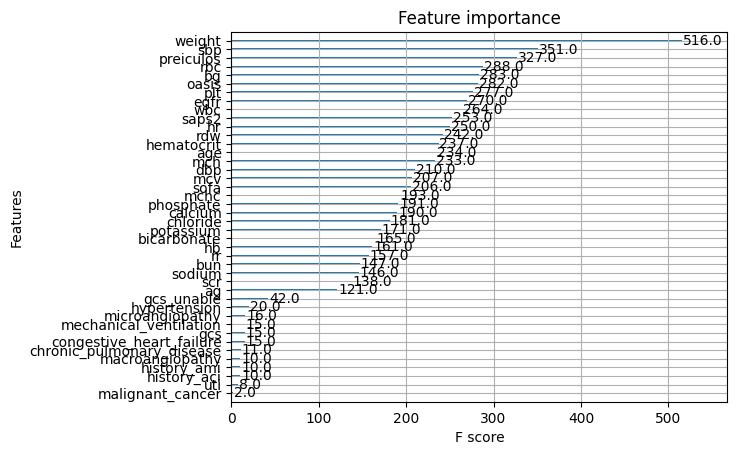

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

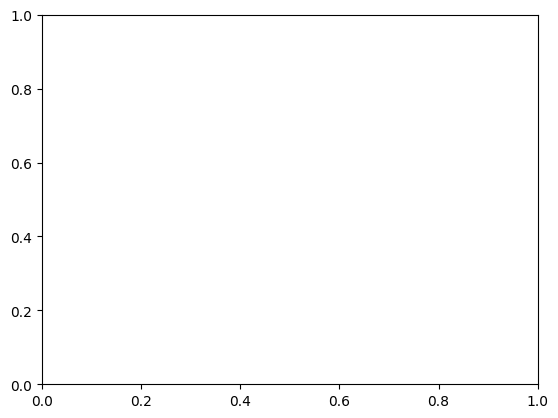

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))



[0]	validation_0-logloss:0.66675


[1]	validation_0-logloss:0.66410


[2]	validation_0-logloss:0.66238


[3]	validation_0-logloss:0.66021


[4]	validation_0-logloss:0.65792


[5]	validation_0-logloss:0.65542


[6]	validation_0-logloss:0.65329


[7]	validation_0-logloss:0.65050


[8]	validation_0-logloss:0.64806


[9]	validation_0-logloss:0.64604


[10]	validation_0-logloss:0.64409


[11]	validation_0-logloss:0.64254


[12]	validation_0-logloss:0.64109


[13]	validation_0-logloss:0.63905


[14]	validation_0-logloss:0.63727


[15]	validation_0-logloss:0.63536


[16]	validation_0-logloss:0.63315


[17]	validation_0-logloss:0.63117


[18]	validation_0-logloss:0.63023


[19]	validation_0-logloss:0.62846


[20]	validation_0-logloss:0.62659


[21]	validation_0-logloss:0.62498


[22]	validation_0-logloss:0.62287


[23]	validation_0-logloss:0.62175


[24]	validation_0-logloss:0.62104


[25]	validation_0-logloss:0.61925


[26]	validation_0-logloss:0.61828


[27]	validation_0-logloss:0.61669


[28]	validation_0-logloss:0.61476


[29]	validation_0-logloss:0.61319


[30]	validation_0-logloss:0.61171


[31]	validation_0-logloss:0.61069


[32]	validation_0-logloss:0.60941


[33]	validation_0-logloss:0.60830


[34]	validation_0-logloss:0.60678


[35]	validation_0-logloss:0.60541


[36]	validation_0-logloss:0.60376


[37]	validation_0-logloss:0.60203


[38]	validation_0-logloss:0.60089


[39]	validation_0-logloss:0.59977


[40]	validation_0-logloss:0.59828


[41]	validation_0-logloss:0.59720


[42]	validation_0-logloss:0.59594


[43]	validation_0-logloss:0.59453


[44]	validation_0-logloss:0.59296


[45]	validation_0-logloss:0.59123


[46]	validation_0-logloss:0.59068


[47]	validation_0-logloss:0.58927


[48]	validation_0-logloss:0.58806


[49]	validation_0-logloss:0.58713


[50]	validation_0-logloss:0.58600


[51]	validation_0-logloss:0.58490


[52]	validation_0-logloss:0.58356


[53]	validation_0-logloss:0.58231


[54]	validation_0-logloss:0.58102


[55]	validation_0-logloss:0.57982


[56]	validation_0-logloss:0.57905


[57]	validation_0-logloss:0.57803


[58]	validation_0-logloss:0.57693


[59]	validation_0-logloss:0.57572


[60]	validation_0-logloss:0.57473


[61]	validation_0-logloss:0.57373


[62]	validation_0-logloss:0.57274


[63]	validation_0-logloss:0.57172


[64]	validation_0-logloss:0.57101


[65]	validation_0-logloss:0.57021


[66]	validation_0-logloss:0.56914


[67]	validation_0-logloss:0.56848


[68]	validation_0-logloss:0.56786


[69]	validation_0-logloss:0.56694


[70]	validation_0-logloss:0.56613


[71]	validation_0-logloss:0.56530


[72]	validation_0-logloss:0.56454


[73]	validation_0-logloss:0.56324


[74]	validation_0-logloss:0.56233


[75]	validation_0-logloss:0.56161


[76]	validation_0-logloss:0.56139


[77]	validation_0-logloss:0.56075


[78]	validation_0-logloss:0.56030


[79]	validation_0-logloss:0.56026


[80]	validation_0-logloss:0.55941


[81]	validation_0-logloss:0.55860


[82]	validation_0-logloss:0.55776


[83]	validation_0-logloss:0.55714


[84]	validation_0-logloss:0.55639


[85]	validation_0-logloss:0.55580


[86]	validation_0-logloss:0.55586


[87]	validation_0-logloss:0.55523


[88]	validation_0-logloss:0.55458


[89]	validation_0-logloss:0.55353


[90]	validation_0-logloss:0.55280


[91]	validation_0-logloss:0.55185


[92]	validation_0-logloss:0.55120


[93]	validation_0-logloss:0.55047


[94]	validation_0-logloss:0.54982


[95]	validation_0-logloss:0.54915


[96]	validation_0-logloss:0.54895


[97]	validation_0-logloss:0.54875


[98]	validation_0-logloss:0.54838


[99]	validation_0-logloss:0.54788


[100]	validation_0-logloss:0.54803


[101]	validation_0-logloss:0.54766


[102]	validation_0-logloss:0.54730


[103]	validation_0-logloss:0.54628


[104]	validation_0-logloss:0.54615


[105]	validation_0-logloss:0.54544


[106]	validation_0-logloss:0.54490


[107]	validation_0-logloss:0.54456


[108]	validation_0-logloss:0.54430


[109]	validation_0-logloss:0.54380


[110]	validation_0-logloss:0.54419


[111]	validation_0-logloss:0.54430


[112]	validation_0-logloss:0.54365


[113]	validation_0-logloss:0.54297


[114]	validation_0-logloss:0.54260


[115]	validation_0-logloss:0.54249


[116]	validation_0-logloss:0.54224


[117]	validation_0-logloss:0.54185


[118]	validation_0-logloss:0.54175


[119]	validation_0-logloss:0.54174


[120]	validation_0-logloss:0.54134


[121]	validation_0-logloss:0.54115


[122]	validation_0-logloss:0.54100


[123]	validation_0-logloss:0.54039


[124]	validation_0-logloss:0.53998


[125]	validation_0-logloss:0.53953


[126]	validation_0-logloss:0.53933


[127]	validation_0-logloss:0.53899


[128]	validation_0-logloss:0.53848


[129]	validation_0-logloss:0.53818


[130]	validation_0-logloss:0.53743


[131]	validation_0-logloss:0.53707


[132]	validation_0-logloss:0.53637


[133]	validation_0-logloss:0.53609


[134]	validation_0-logloss:0.53569


[135]	validation_0-logloss:0.53522


[136]	validation_0-logloss:0.53495


[137]	validation_0-logloss:0.53493


[138]	validation_0-logloss:0.53497


[139]	validation_0-logloss:0.53504


[140]	validation_0-logloss:0.53459


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:14:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[141]	validation_0-logloss:0.53404


[142]	validation_0-logloss:0.53298


[143]	validation_0-logloss:0.53289


[144]	validation_0-logloss:0.53296


[145]	validation_0-logloss:0.53268


[146]	validation_0-logloss:0.53256


[147]	validation_0-logloss:0.53214


[148]	validation_0-logloss:0.53147


[149]	validation_0-logloss:0.53137


[150]	validation_0-logloss:0.53102


[151]	validation_0-logloss:0.53081


[152]	validation_0-logloss:0.53054


[153]	validation_0-logloss:0.53019


[154]	validation_0-logloss:0.53016


[155]	validation_0-logloss:0.52955


[156]	validation_0-logloss:0.52957


[157]	validation_0-logloss:0.52963


[158]	validation_0-logloss:0.52951


[159]	validation_0-logloss:0.52885


[160]	validation_0-logloss:0.52888


[161]	validation_0-logloss:0.52832


[162]	validation_0-logloss:0.52804


[163]	validation_0-logloss:0.52781


[164]	validation_0-logloss:0.52763


[165]	validation_0-logloss:0.52755


[166]	validation_0-logloss:0.52720


[167]	validation_0-logloss:0.52727


[168]	validation_0-logloss:0.52685


[169]	validation_0-logloss:0.52665


[170]	validation_0-logloss:0.52647


[171]	validation_0-logloss:0.52663


[172]	validation_0-logloss:0.52667


[173]	validation_0-logloss:0.52626


[174]	validation_0-logloss:0.52615


[175]	validation_0-logloss:0.52564


[176]	validation_0-logloss:0.52530


[177]	validation_0-logloss:0.52533


[178]	validation_0-logloss:0.52525


[179]	validation_0-logloss:0.52522


[180]	validation_0-logloss:0.52517

[181]	validation_0-logloss:0.52492


[182]	validation_0-logloss:0.52459


[183]	validation_0-logloss:0.52440


[184]	validation_0-logloss:0.52443


[185]	validation_0-logloss:0.52419


[186]	validation_0-logloss:0.52408


[187]	validation_0-logloss:0.52403


[188]	validation_0-logloss:0.52374


[189]	validation_0-logloss:0.52352


[190]	validation_0-logloss:0.52356


[191]	validation_0-logloss:0.52343


[192]	validation_0-logloss:0.52339


[193]	validation_0-logloss:0.52289


[194]	validation_0-logloss:0.52280


[195]	validation_0-logloss:0.52254


[196]	validation_0-logloss:0.52240


[197]	validation_0-logloss:0.52196


[198]	validation_0-logloss:0.52208


[199]	validation_0-logloss:0.52211

[200]	validation_0-logloss:0.52159


[201]	validation_0-logloss:0.52150


[202]	validation_0-logloss:0.52128


[203]	validation_0-logloss:0.52122


[204]	validation_0-logloss:0.52097


[205]	validation_0-logloss:0.52104


[206]	validation_0-logloss:0.52093


[207]	validation_0-logloss:0.52043


[208]	validation_0-logloss:0.52038


[209]	validation_0-logloss:0.52024


[210]	validation_0-logloss:0.51998


[211]	validation_0-logloss:0.52019


[212]	validation_0-logloss:0.52017


[213]	validation_0-logloss:0.52006


[214]	validation_0-logloss:0.51990


[215]	validation_0-logloss:0.52001


[216]	validation_0-logloss:0.51981


[217]	validation_0-logloss:0.51977


[218]	validation_0-logloss:0.51969


[219]	validation_0-logloss:0.51977


[220]	validation_0-logloss:0.51934


[221]	validation_0-logloss:0.51947


[222]	validation_0-logloss:0.51938


[223]	validation_0-logloss:0.51913


[224]	validation_0-logloss:0.51873


[225]	validation_0-logloss:0.51876


[226]	validation_0-logloss:0.51876


[227]	validation_0-logloss:0.51883


[228]	validation_0-logloss:0.51855


[229]	validation_0-logloss:0.51840


[230]	validation_0-logloss:0.51832


[231]	validation_0-logloss:0.51848


[232]	validation_0-logloss:0.51817


[233]	validation_0-logloss:0.51802


[234]	validation_0-logloss:0.51735


[235]	validation_0-logloss:0.51707


[236]	validation_0-logloss:0.51714


[237]	validation_0-logloss:0.51723


[238]	validation_0-logloss:0.51722


[239]	validation_0-logloss:0.51728


[240]	validation_0-logloss:0.51724


[241]	validation_0-logloss:0.51694


[242]	validation_0-logloss:0.51641


[243]	validation_0-logloss:0.51641


[244]	validation_0-logloss:0.51647


[245]	validation_0-logloss:0.51657


[246]	validation_0-logloss:0.51659


[247]	validation_0-logloss:0.51644


[248]	validation_0-logloss:0.51653


[249]	validation_0-logloss:0.51646


[250]	validation_0-logloss:0.51660


[251]	validation_0-logloss:0.51672


[0]	validation_0-logloss:0.66785


[1]	validation_0-logloss:0.66525


[2]	validation_0-logloss:0.66267


[3]	validation_0-logloss:0.66060


[4]	validation_0-logloss:0.65769


[5]	validation_0-logloss:0.65534


[6]	validation_0-logloss:0.65385


[7]	validation_0-logloss:0.65160


[8]	validation_0-logloss:0.64951


[9]	validation_0-logloss:0.64739


[10]	validation_0-logloss:0.64590


[11]	validation_0-logloss:0.64391


[12]	validation_0-logloss:0.64263


[13]	validation_0-logloss:0.64021


[14]	validation_0-logloss:0.63810


[15]	validation_0-logloss:0.63618


[16]	validation_0-logloss:0.63482


[17]	validation_0-logloss:0.63351


[18]	validation_0-logloss:0.63190


[19]	validation_0-logloss:0.62969


[20]	validation_0-logloss:0.62794


[21]	validation_0-logloss:0.62598


[22]	validation_0-logloss:0.62372


[23]	validation_0-logloss:0.62228


[24]	validation_0-logloss:0.62035


[25]	validation_0-logloss:0.61879


[26]	validation_0-logloss:0.61761


[27]	validation_0-logloss:0.61630


[28]	validation_0-logloss:0.61434


[29]	validation_0-logloss:0.61286


[30]	validation_0-logloss:0.61146


[31]	validation_0-logloss:0.60995


[32]	validation_0-logloss:0.60949


[33]	validation_0-logloss:0.60792


[34]	validation_0-logloss:0.60681


[35]	validation_0-logloss:0.60524


[36]	validation_0-logloss:0.60323


[37]	validation_0-logloss:0.60217


[38]	validation_0-logloss:0.60083


[39]	validation_0-logloss:0.59958


[40]	validation_0-logloss:0.59798


[41]	validation_0-logloss:0.59665


[42]	validation_0-logloss:0.59532


[43]	validation_0-logloss:0.59421


[44]	validation_0-logloss:0.59270


[45]	validation_0-logloss:0.59140


[46]	validation_0-logloss:0.59045


[47]	validation_0-logloss:0.58894


[48]	validation_0-logloss:0.58787


[49]	validation_0-logloss:0.58739


[50]	validation_0-logloss:0.58620


[51]	validation_0-logloss:0.58511


[52]	validation_0-logloss:0.58419


[53]	validation_0-logloss:0.58355


[54]	validation_0-logloss:0.58235


[55]	validation_0-logloss:0.58120


[56]	validation_0-logloss:0.57985


[57]	validation_0-logloss:0.57842


[58]	validation_0-logloss:0.57752


[59]	validation_0-logloss:0.57667


[60]	validation_0-logloss:0.57547


[61]	validation_0-logloss:0.57477


[62]	validation_0-logloss:0.57363


[63]	validation_0-logloss:0.57290


[64]	validation_0-logloss:0.57193


[65]	validation_0-logloss:0.57067


[66]	validation_0-logloss:0.56983


[67]	validation_0-logloss:0.56894


[68]	validation_0-logloss:0.56812


[69]	validation_0-logloss:0.56714


[70]	validation_0-logloss:0.56618


[71]	validation_0-logloss:0.56511


[72]	validation_0-logloss:0.56465


[73]	validation_0-logloss:0.56381


[74]	validation_0-logloss:0.56276


[75]	validation_0-logloss:0.56201


[76]	validation_0-logloss:0.56149


[77]	validation_0-logloss:0.56103


[78]	validation_0-logloss:0.56029


[79]	validation_0-logloss:0.55917


[80]	validation_0-logloss:0.55848


[81]	validation_0-logloss:0.55777


[82]	validation_0-logloss:0.55712


[83]	validation_0-logloss:0.55623


[84]	validation_0-logloss:0.55553


[85]	validation_0-logloss:0.55543


[86]	validation_0-logloss:0.55488


[87]	validation_0-logloss:0.55380


[88]	validation_0-logloss:0.55321


[89]	validation_0-logloss:0.55290


[90]	validation_0-logloss:0.55232


[91]	validation_0-logloss:0.55149


[92]	validation_0-logloss:0.55066


[93]	validation_0-logloss:0.55000


[94]	validation_0-logloss:0.54918


[95]	validation_0-logloss:0.54872


[96]	validation_0-logloss:0.54818


[97]	validation_0-logloss:0.54762


[98]	validation_0-logloss:0.54681


[99]	validation_0-logloss:0.54635


[100]	validation_0-logloss:0.54567


[101]	validation_0-logloss:0.54527


[102]	validation_0-logloss:0.54482


[103]	validation_0-logloss:0.54411


[104]	validation_0-logloss:0.54369


[105]	validation_0-logloss:0.54300


[106]	validation_0-logloss:0.54263


[107]	validation_0-logloss:0.54203


[108]	validation_0-logloss:0.54152


[109]	validation_0-logloss:0.54107


[110]	validation_0-logloss:0.54021


[111]	validation_0-logloss:0.53965


[112]	validation_0-logloss:0.53897


[113]	validation_0-logloss:0.53882


[114]	validation_0-logloss:0.53824


[115]	validation_0-logloss:0.53782


[116]	validation_0-logloss:0.53689


[117]	validation_0-logloss:0.53660


[118]	validation_0-logloss:0.53613


[119]	validation_0-logloss:0.53567


[120]	validation_0-logloss:0.53502


[121]	validation_0-logloss:0.53402


[122]	validation_0-logloss:0.53339


[123]	validation_0-logloss:0.53294


[124]	validation_0-logloss:0.53207


[125]	validation_0-logloss:0.53174


[126]	validation_0-logloss:0.53103


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:15:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[127]	validation_0-logloss:0.53093


[128]	validation_0-logloss:0.53044


[129]	validation_0-logloss:0.52992


[130]	validation_0-logloss:0.52917


[131]	validation_0-logloss:0.52861


[132]	validation_0-logloss:0.52845


[133]	validation_0-logloss:0.52755


[134]	validation_0-logloss:0.52697


[135]	validation_0-logloss:0.52651


[136]	validation_0-logloss:0.52590


[137]	validation_0-logloss:0.52542


[138]	validation_0-logloss:0.52538


[139]	validation_0-logloss:0.52497


[140]	validation_0-logloss:0.52485


[141]	validation_0-logloss:0.52438


[142]	validation_0-logloss:0.52401


[143]	validation_0-logloss:0.52351


[144]	validation_0-logloss:0.52363


[145]	validation_0-logloss:0.52320


[146]	validation_0-logloss:0.52281


[147]	validation_0-logloss:0.52226


[148]	validation_0-logloss:0.52200


[149]	validation_0-logloss:0.52184


[150]	validation_0-logloss:0.52146


[151]	validation_0-logloss:0.52117


[152]	validation_0-logloss:0.52076


[153]	validation_0-logloss:0.52033


[154]	validation_0-logloss:0.51995


[155]	validation_0-logloss:0.52001


[156]	validation_0-logloss:0.51989


[157]	validation_0-logloss:0.51953


[158]	validation_0-logloss:0.51928


[159]	validation_0-logloss:0.51873


[160]	validation_0-logloss:0.51882


[161]	validation_0-logloss:0.51851


[162]	validation_0-logloss:0.51866


[163]	validation_0-logloss:0.51874


[164]	validation_0-logloss:0.51856


[165]	validation_0-logloss:0.51829


[166]	validation_0-logloss:0.51791


[167]	validation_0-logloss:0.51755


[168]	validation_0-logloss:0.51755


[169]	validation_0-logloss:0.51746


[170]	validation_0-logloss:0.51735


[171]	validation_0-logloss:0.51700


[172]	validation_0-logloss:0.51691


[173]	validation_0-logloss:0.51675


[174]	validation_0-logloss:0.51609

[175]	validation_0-logloss:0.51577


[176]	validation_0-logloss:0.51586


[177]	validation_0-logloss:0.51580

[178]	validation_0-logloss:0.51563


[179]	validation_0-logloss:0.51541


[180]	validation_0-logloss:0.51519


[181]	validation_0-logloss:0.51535


[182]	validation_0-logloss:0.51537


[183]	validation_0-logloss:0.51500


[184]	validation_0-logloss:0.51495


[185]	validation_0-logloss:0.51469


[186]	validation_0-logloss:0.51467


[187]	validation_0-logloss:0.51441


[188]	validation_0-logloss:0.51405


[189]	validation_0-logloss:0.51398


[190]	validation_0-logloss:0.51359


[191]	validation_0-logloss:0.51317


[192]	validation_0-logloss:0.51275


[193]	validation_0-logloss:0.51238


[194]	validation_0-logloss:0.51235


[195]	validation_0-logloss:0.51206


[196]	validation_0-logloss:0.51199


[197]	validation_0-logloss:0.51198


[198]	validation_0-logloss:0.51191


[199]	validation_0-logloss:0.51176


[200]	validation_0-logloss:0.51169


[201]	validation_0-logloss:0.51139


[202]	validation_0-logloss:0.51152


[203]	validation_0-logloss:0.51155


[204]	validation_0-logloss:0.51128


[205]	validation_0-logloss:0.51109


[206]	validation_0-logloss:0.51104


[207]	validation_0-logloss:0.51065


[208]	validation_0-logloss:0.51042


[209]	validation_0-logloss:0.51047


[210]	validation_0-logloss:0.51002


[211]	validation_0-logloss:0.50955


[212]	validation_0-logloss:0.50950


[213]	validation_0-logloss:0.50929


[214]	validation_0-logloss:0.50904


[215]	validation_0-logloss:0.50919


[216]	validation_0-logloss:0.50906


[217]	validation_0-logloss:0.50885


[218]	validation_0-logloss:0.50879


[219]	validation_0-logloss:0.50854


[220]	validation_0-logloss:0.50851


[221]	validation_0-logloss:0.50837


[222]	validation_0-logloss:0.50855


[223]	validation_0-logloss:0.50864


[224]	validation_0-logloss:0.50820


[225]	validation_0-logloss:0.50813


[226]	validation_0-logloss:0.50846


[227]	validation_0-logloss:0.50835


[228]	validation_0-logloss:0.50798


[229]	validation_0-logloss:0.50782


[230]	validation_0-logloss:0.50768


[231]	validation_0-logloss:0.50755


[232]	validation_0-logloss:0.50718


[233]	validation_0-logloss:0.50701


[234]	validation_0-logloss:0.50715


[235]	validation_0-logloss:0.50713


[236]	validation_0-logloss:0.50707


[237]	validation_0-logloss:0.50686


[238]	validation_0-logloss:0.50675


[239]	validation_0-logloss:0.50669


[240]	validation_0-logloss:0.50689


[241]	validation_0-logloss:0.50641


[242]	validation_0-logloss:0.50660


[243]	validation_0-logloss:0.50657


[244]	validation_0-logloss:0.50632


[245]	validation_0-logloss:0.50619


[246]	validation_0-logloss:0.50640


[247]	validation_0-logloss:0.50626


[248]	validation_0-logloss:0.50626


[249]	validation_0-logloss:0.50606


[250]	validation_0-logloss:0.50596


[251]	validation_0-logloss:0.50564


[252]	validation_0-logloss:0.50555


[253]	validation_0-logloss:0.50559


[254]	validation_0-logloss:0.50553


[255]	validation_0-logloss:0.50557


[256]	validation_0-logloss:0.50534


[257]	validation_0-logloss:0.50539


[258]	validation_0-logloss:0.50523


[259]	validation_0-logloss:0.50506


[260]	validation_0-logloss:0.50497


[261]	validation_0-logloss:0.50500


[262]	validation_0-logloss:0.50475


[263]	validation_0-logloss:0.50464


[264]	validation_0-logloss:0.50450


[265]	validation_0-logloss:0.50429


[266]	validation_0-logloss:0.50431


[267]	validation_0-logloss:0.50401


[268]	validation_0-logloss:0.50401


[269]	validation_0-logloss:0.50437


[270]	validation_0-logloss:0.50435


[271]	validation_0-logloss:0.50412


[272]	validation_0-logloss:0.50421


[273]	validation_0-logloss:0.50388


[274]	validation_0-logloss:0.50402


[275]	validation_0-logloss:0.50410


[276]	validation_0-logloss:0.50410


[277]	validation_0-logloss:0.50398


[278]	validation_0-logloss:0.50388


[279]	validation_0-logloss:0.50390


[280]	validation_0-logloss:0.50366


[281]	validation_0-logloss:0.50373


[282]	validation_0-logloss:0.50380


[283]	validation_0-logloss:0.50413


[284]	validation_0-logloss:0.50428


[285]	validation_0-logloss:0.50406


[286]	validation_0-logloss:0.50416


[287]	validation_0-logloss:0.50407


[288]	validation_0-logloss:0.50404


[289]	validation_0-logloss:0.50415


[290]	validation_0-logloss:0.50411


[0]	validation_0-logloss:0.66909


[1]	validation_0-logloss:0.66705


[2]	validation_0-logloss:0.66503


[3]	validation_0-logloss:0.66336


[4]	validation_0-logloss:0.66148


[5]	validation_0-logloss:0.65964


[6]	validation_0-logloss:0.65814


[7]	validation_0-logloss:0.65641


[8]	validation_0-logloss:0.65493


[9]	validation_0-logloss:0.65356


[10]	validation_0-logloss:0.65160


[11]	validation_0-logloss:0.65012


[12]	validation_0-logloss:0.64859


[13]	validation_0-logloss:0.64757


[14]	validation_0-logloss:0.64619


[15]	validation_0-logloss:0.64474


[16]	validation_0-logloss:0.64297


[17]	validation_0-logloss:0.64122


[18]	validation_0-logloss:0.63988


[19]	validation_0-logloss:0.63841


[20]	validation_0-logloss:0.63685


[21]	validation_0-logloss:0.63492


[22]	validation_0-logloss:0.63341


[23]	validation_0-logloss:0.63170


[24]	validation_0-logloss:0.63067


[25]	validation_0-logloss:0.63002


[26]	validation_0-logloss:0.62858


[27]	validation_0-logloss:0.62767


[28]	validation_0-logloss:0.62640


[29]	validation_0-logloss:0.62499


[30]	validation_0-logloss:0.62401


[31]	validation_0-logloss:0.62354


[32]	validation_0-logloss:0.62244


[33]	validation_0-logloss:0.62106


[34]	validation_0-logloss:0.62016


[35]	validation_0-logloss:0.61921


[36]	validation_0-logloss:0.61772


[37]	validation_0-logloss:0.61697


[38]	validation_0-logloss:0.61560


[39]	validation_0-logloss:0.61478


[40]	validation_0-logloss:0.61401


[41]	validation_0-logloss:0.61293


[42]	validation_0-logloss:0.61193


[43]	validation_0-logloss:0.61068


[44]	validation_0-logloss:0.60996


[45]	validation_0-logloss:0.60922


[46]	validation_0-logloss:0.60864


[47]	validation_0-logloss:0.60848


[48]	validation_0-logloss:0.60796


[49]	validation_0-logloss:0.60725


[50]	validation_0-logloss:0.60667


[51]	validation_0-logloss:0.60582


[52]	validation_0-logloss:0.60448


[53]	validation_0-logloss:0.60342


[54]	validation_0-logloss:0.60215


[55]	validation_0-logloss:0.60130


[56]	validation_0-logloss:0.60041


[57]	validation_0-logloss:0.59951


[58]	validation_0-logloss:0.59872


[59]	validation_0-logloss:0.59830


[60]	validation_0-logloss:0.59741


[61]	validation_0-logloss:0.59659


[62]	validation_0-logloss:0.59633


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:15:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[63]	validation_0-logloss:0.59529


[64]	validation_0-logloss:0.59482


[65]	validation_0-logloss:0.59476


[66]	validation_0-logloss:0.59445


[67]	validation_0-logloss:0.59393


[68]	validation_0-logloss:0.59297


[69]	validation_0-logloss:0.59237


[70]	validation_0-logloss:0.59195


[71]	validation_0-logloss:0.59184


[72]	validation_0-logloss:0.59163


[73]	validation_0-logloss:0.59051


[74]	validation_0-logloss:0.58959


[75]	validation_0-logloss:0.58872


[76]	validation_0-logloss:0.58822


[77]	validation_0-logloss:0.58798


[78]	validation_0-logloss:0.58726


[79]	validation_0-logloss:0.58682


[80]	validation_0-logloss:0.58633


[81]	validation_0-logloss:0.58613


[82]	validation_0-logloss:0.58563


[83]	validation_0-logloss:0.58552


[84]	validation_0-logloss:0.58478


[85]	validation_0-logloss:0.58456


[86]	validation_0-logloss:0.58376


[87]	validation_0-logloss:0.58283


[88]	validation_0-logloss:0.58206


[89]	validation_0-logloss:0.58155


[90]	validation_0-logloss:0.58077


[91]	validation_0-logloss:0.58025


[92]	validation_0-logloss:0.57992


[93]	validation_0-logloss:0.57938


[94]	validation_0-logloss:0.57885


[95]	validation_0-logloss:0.57869


[96]	validation_0-logloss:0.57823


[97]	validation_0-logloss:0.57782


[98]	validation_0-logloss:0.57764


[99]	validation_0-logloss:0.57780


[100]	validation_0-logloss:0.57767


[101]	validation_0-logloss:0.57759


[102]	validation_0-logloss:0.57704


[103]	validation_0-logloss:0.57668


[104]	validation_0-logloss:0.57629


[105]	validation_0-logloss:0.57634


[106]	validation_0-logloss:0.57583


[107]	validation_0-logloss:0.57543


[108]	validation_0-logloss:0.57488


[109]	validation_0-logloss:0.57483


[110]	validation_0-logloss:0.57452


[111]	validation_0-logloss:0.57422


[112]	validation_0-logloss:0.57375


[113]	validation_0-logloss:0.57333


[114]	validation_0-logloss:0.57297


[115]	validation_0-logloss:0.57265


[116]	validation_0-logloss:0.57236


[117]	validation_0-logloss:0.57196


[118]	validation_0-logloss:0.57197


[119]	validation_0-logloss:0.57179


[120]	validation_0-logloss:0.57198


[121]	validation_0-logloss:0.57201


[122]	validation_0-logloss:0.57204


[123]	validation_0-logloss:0.57144


[124]	validation_0-logloss:0.57159


[125]	validation_0-logloss:0.57152


[126]	validation_0-logloss:0.57150


[127]	validation_0-logloss:0.57127


[128]	validation_0-logloss:0.57090


[129]	validation_0-logloss:0.57066


[130]	validation_0-logloss:0.57034


[131]	validation_0-logloss:0.56988


[132]	validation_0-logloss:0.56961


[133]	validation_0-logloss:0.56939


[134]	validation_0-logloss:0.56896


[135]	validation_0-logloss:0.56868


[136]	validation_0-logloss:0.56853


[137]	validation_0-logloss:0.56857


[138]	validation_0-logloss:0.56817


[139]	validation_0-logloss:0.56786


[140]	validation_0-logloss:0.56761


[141]	validation_0-logloss:0.56724


[142]	validation_0-logloss:0.56709


[143]	validation_0-logloss:0.56701


[144]	validation_0-logloss:0.56655


[145]	validation_0-logloss:0.56622


[146]	validation_0-logloss:0.56588


[147]	validation_0-logloss:0.56590


[148]	validation_0-logloss:0.56550


[149]	validation_0-logloss:0.56534


[150]	validation_0-logloss:0.56538


[151]	validation_0-logloss:0.56496


[152]	validation_0-logloss:0.56516


[153]	validation_0-logloss:0.56485


[154]	validation_0-logloss:0.56471


[155]	validation_0-logloss:0.56475


[156]	validation_0-logloss:0.56474


[157]	validation_0-logloss:0.56464


[158]	validation_0-logloss:0.56466


[159]	validation_0-logloss:0.56463


[160]	validation_0-logloss:0.56442


[161]	validation_0-logloss:0.56428


[162]	validation_0-logloss:0.56427


[163]	validation_0-logloss:0.56436


[164]	validation_0-logloss:0.56427


[165]	validation_0-logloss:0.56404


[166]	validation_0-logloss:0.56386


[167]	validation_0-logloss:0.56365


[168]	validation_0-logloss:0.56348


[169]	validation_0-logloss:0.56311


[170]	validation_0-logloss:0.56318


[171]	validation_0-logloss:0.56312


[172]	validation_0-logloss:0.56269


[173]	validation_0-logloss:0.56236


[174]	validation_0-logloss:0.56216


[175]	validation_0-logloss:0.56190


[176]	validation_0-logloss:0.56166


[177]	validation_0-logloss:0.56166


[178]	validation_0-logloss:0.56164


[179]	validation_0-logloss:0.56161


[180]	validation_0-logloss:0.56153


[181]	validation_0-logloss:0.56132


[182]	validation_0-logloss:0.56086


[183]	validation_0-logloss:0.56074


[184]	validation_0-logloss:0.56049


[185]	validation_0-logloss:0.56023


[186]	validation_0-logloss:0.56042


[187]	validation_0-logloss:0.56048


[188]	validation_0-logloss:0.56043


[189]	validation_0-logloss:0.56009


[190]	validation_0-logloss:0.56006


[191]	validation_0-logloss:0.55981


[192]	validation_0-logloss:0.55972


[193]	validation_0-logloss:0.55990


[194]	validation_0-logloss:0.55957


[195]	validation_0-logloss:0.55961


[196]	validation_0-logloss:0.55966


[197]	validation_0-logloss:0.55972


[198]	validation_0-logloss:0.55963


[199]	validation_0-logloss:0.55979


[200]	validation_0-logloss:0.55969


[201]	validation_0-logloss:0.55944


[202]	validation_0-logloss:0.55920


[203]	validation_0-logloss:0.55915


[204]	validation_0-logloss:0.55936


[205]	validation_0-logloss:0.55940


[206]	validation_0-logloss:0.55952


[207]	validation_0-logloss:0.55950


[208]	validation_0-logloss:0.55940


[209]	validation_0-logloss:0.55967


[210]	validation_0-logloss:0.55977


[211]	validation_0-logloss:0.55951


[212]	validation_0-logloss:0.55927


[213]	validation_0-logloss:0.55894


[214]	validation_0-logloss:0.55876


[215]	validation_0-logloss:0.55877


[216]	validation_0-logloss:0.55854


[217]	validation_0-logloss:0.55898


[218]	validation_0-logloss:0.55906


[219]	validation_0-logloss:0.55911


[220]	validation_0-logloss:0.55890


[221]	validation_0-logloss:0.55882


[222]	validation_0-logloss:0.55841


[223]	validation_0-logloss:0.55819

[224]	validation_0-logloss:0.55818


[225]	validation_0-logloss:0.55842


[226]	validation_0-logloss:0.55841


[227]	validation_0-logloss:0.55836


[228]	validation_0-logloss:0.55870


[229]	validation_0-logloss:0.55878


[230]	validation_0-logloss:0.55892


[231]	validation_0-logloss:0.55867


[232]	validation_0-logloss:0.55847


[233]	validation_0-logloss:0.55847


[234]	validation_0-logloss:0.55830


[0]	validation_0-logloss:0.66827


[1]	validation_0-logloss:0.66617


[2]	validation_0-logloss:0.66365


[3]	validation_0-logloss:0.66199


[4]	validation_0-logloss:0.66006


[5]	validation_0-logloss:0.65779


[6]	validation_0-logloss:0.65603


[7]	validation_0-logloss:0.65411


[8]	validation_0-logloss:0.65149


[9]	validation_0-logloss:0.65012


[10]	validation_0-logloss:0.64886


[11]	validation_0-logloss:0.64688


[12]	validation_0-logloss:0.64498


[13]	validation_0-logloss:0.64321


[14]	validation_0-logloss:0.64130


[15]	validation_0-logloss:0.63954


[16]	validation_0-logloss:0.63764


[17]	validation_0-logloss:0.63599


[18]	validation_0-logloss:0.63483


[19]	validation_0-logloss:0.63377


[20]	validation_0-logloss:0.63165


[21]	validation_0-logloss:0.63062


[22]	validation_0-logloss:0.62866


[23]	validation_0-logloss:0.62710


[24]	validation_0-logloss:0.62573


[25]	validation_0-logloss:0.62389


[26]	validation_0-logloss:0.62214


[27]	validation_0-logloss:0.62027


[28]	validation_0-logloss:0.61890


[29]	validation_0-logloss:0.61812


[30]	validation_0-logloss:0.61657


[31]	validation_0-logloss:0.61509


[32]	validation_0-logloss:0.61427


[33]	validation_0-logloss:0.61268


[34]	validation_0-logloss:0.61112


[35]	validation_0-logloss:0.61019


[36]	validation_0-logloss:0.60894


[37]	validation_0-logloss:0.60723


[38]	validation_0-logloss:0.60607


[39]	validation_0-logloss:0.60513


[40]	validation_0-logloss:0.60344


[41]	validation_0-logloss:0.60247


[42]	validation_0-logloss:0.60154


[43]	validation_0-logloss:0.60061


[44]	validation_0-logloss:0.59937


[45]	validation_0-logloss:0.59840


[46]	validation_0-logloss:0.59701


[47]	validation_0-logloss:0.59598


[48]	validation_0-logloss:0.59480


[49]	validation_0-logloss:0.59425


[50]	validation_0-logloss:0.59281


[51]	validation_0-logloss:0.59173


[52]	validation_0-logloss:0.59083


[53]	validation_0-logloss:0.59003


[54]	validation_0-logloss:0.58902


[55]	validation_0-logloss:0.58752


[56]	validation_0-logloss:0.58665


[57]	validation_0-logloss:0.58579


[58]	validation_0-logloss:0.58479


[59]	validation_0-logloss:0.58424


[60]	validation_0-logloss:0.58334


[61]	validation_0-logloss:0.58212


[62]	validation_0-logloss:0.58113


[63]	validation_0-logloss:0.58046


[64]	validation_0-logloss:0.58013


[65]	validation_0-logloss:0.57963


[66]	validation_0-logloss:0.57926


[67]	validation_0-logloss:0.57855


[68]	validation_0-logloss:0.57766


[69]	validation_0-logloss:0.57721


[70]	validation_0-logloss:0.57651


[71]	validation_0-logloss:0.57582


[72]	validation_0-logloss:0.57512


[73]	validation_0-logloss:0.57445


[74]	validation_0-logloss:0.57358


[75]	validation_0-logloss:0.57259


[76]	validation_0-logloss:0.57196


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:15:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[77]	validation_0-logloss:0.57131


[78]	validation_0-logloss:0.57000


[79]	validation_0-logloss:0.56911


[80]	validation_0-logloss:0.56828


[81]	validation_0-logloss:0.56780


[82]	validation_0-logloss:0.56703


[83]	validation_0-logloss:0.56639


[84]	validation_0-logloss:0.56555


[85]	validation_0-logloss:0.56466


[86]	validation_0-logloss:0.56400


[87]	validation_0-logloss:0.56328


[88]	validation_0-logloss:0.56280


[89]	validation_0-logloss:0.56185


[90]	validation_0-logloss:0.56156


[91]	validation_0-logloss:0.56133

[92]	validation_0-logloss:0.56101


[93]	validation_0-logloss:0.56064


[94]	validation_0-logloss:0.56050


[95]	validation_0-logloss:0.56023


[96]	validation_0-logloss:0.55996


[97]	validation_0-logloss:0.55969


[98]	validation_0-logloss:0.55920


[99]	validation_0-logloss:0.55862


[100]	validation_0-logloss:0.55841


[101]	validation_0-logloss:0.55793


[102]	validation_0-logloss:0.55720


[103]	validation_0-logloss:0.55661


[104]	validation_0-logloss:0.55629


[105]	validation_0-logloss:0.55629


[106]	validation_0-logloss:0.55599


[107]	validation_0-logloss:0.55528


[108]	validation_0-logloss:0.55419


[109]	validation_0-logloss:0.55418


[110]	validation_0-logloss:0.55358


[111]	validation_0-logloss:0.55366


[112]	validation_0-logloss:0.55332


[113]	validation_0-logloss:0.55336


[114]	validation_0-logloss:0.55296


[115]	validation_0-logloss:0.55252


[116]	validation_0-logloss:0.55209


[117]	validation_0-logloss:0.55174


[118]	validation_0-logloss:0.55167


[119]	validation_0-logloss:0.55104


[120]	validation_0-logloss:0.55092


[121]	validation_0-logloss:0.55085


[122]	validation_0-logloss:0.55083


[123]	validation_0-logloss:0.55058


[124]	validation_0-logloss:0.55028


[125]	validation_0-logloss:0.54984


[126]	validation_0-logloss:0.54942


[127]	validation_0-logloss:0.54897


[128]	validation_0-logloss:0.54862


[129]	validation_0-logloss:0.54838


[130]	validation_0-logloss:0.54807


[131]	validation_0-logloss:0.54772


[132]	validation_0-logloss:0.54739


[133]	validation_0-logloss:0.54713


[134]	validation_0-logloss:0.54709


[135]	validation_0-logloss:0.54662


[136]	validation_0-logloss:0.54687


[137]	validation_0-logloss:0.54712


[138]	validation_0-logloss:0.54688


[139]	validation_0-logloss:0.54656


[140]	validation_0-logloss:0.54594


[141]	validation_0-logloss:0.54590


[142]	validation_0-logloss:0.54598


[143]	validation_0-logloss:0.54583


[144]	validation_0-logloss:0.54589


[145]	validation_0-logloss:0.54554


[146]	validation_0-logloss:0.54502


[147]	validation_0-logloss:0.54492


[148]	validation_0-logloss:0.54469


[149]	validation_0-logloss:0.54466


[150]	validation_0-logloss:0.54446


[151]	validation_0-logloss:0.54444


[152]	validation_0-logloss:0.54412


[153]	validation_0-logloss:0.54401


[154]	validation_0-logloss:0.54349


[155]	validation_0-logloss:0.54347


[156]	validation_0-logloss:0.54307


[157]	validation_0-logloss:0.54293


[158]	validation_0-logloss:0.54285


[159]	validation_0-logloss:0.54250


[160]	validation_0-logloss:0.54202


[161]	validation_0-logloss:0.54203


[162]	validation_0-logloss:0.54167


[163]	validation_0-logloss:0.54107


[164]	validation_0-logloss:0.54119


[165]	validation_0-logloss:0.54105


[166]	validation_0-logloss:0.54070


[167]	validation_0-logloss:0.54045


[168]	validation_0-logloss:0.54034


[169]	validation_0-logloss:0.54043


[170]	validation_0-logloss:0.54035


[171]	validation_0-logloss:0.53994


[172]	validation_0-logloss:0.54002


[173]	validation_0-logloss:0.53991


[174]	validation_0-logloss:0.53973


[175]	validation_0-logloss:0.53944


[176]	validation_0-logloss:0.53905


[177]	validation_0-logloss:0.53880


[178]	validation_0-logloss:0.53838


[179]	validation_0-logloss:0.53841


[180]	validation_0-logloss:0.53832


[181]	validation_0-logloss:0.53822


[182]	validation_0-logloss:0.53806


[183]	validation_0-logloss:0.53781


[184]	validation_0-logloss:0.53803


[185]	validation_0-logloss:0.53806


[186]	validation_0-logloss:0.53824


[187]	validation_0-logloss:0.53825


[188]	validation_0-logloss:0.53818


[189]	validation_0-logloss:0.53814


[190]	validation_0-logloss:0.53798


[191]	validation_0-logloss:0.53771


[192]	validation_0-logloss:0.53761


[193]	validation_0-logloss:0.53751


[194]	validation_0-logloss:0.53749


[195]	validation_0-logloss:0.53708


[196]	validation_0-logloss:0.53722


[197]	validation_0-logloss:0.53690


[198]	validation_0-logloss:0.53678


[199]	validation_0-logloss:0.53631


[200]	validation_0-logloss:0.53651


[201]	validation_0-logloss:0.53640


[202]	validation_0-logloss:0.53648


[203]	validation_0-logloss:0.53651


[204]	validation_0-logloss:0.53650


[205]	validation_0-logloss:0.53656


[206]	validation_0-logloss:0.53647


[207]	validation_0-logloss:0.53655


[208]	validation_0-logloss:0.53647


[209]	validation_0-logloss:0.53664


[0]	validation_0-logloss:0.66754


[1]	validation_0-logloss:0.66544


[2]	validation_0-logloss:0.66302


[3]	validation_0-logloss:0.66142


[4]	validation_0-logloss:0.65943


[5]	validation_0-logloss:0.65788


[6]	validation_0-logloss:0.65634


[7]	validation_0-logloss:0.65454


[8]	validation_0-logloss:0.65225


[9]	validation_0-logloss:0.65061


[10]	validation_0-logloss:0.64899


[11]	validation_0-logloss:0.64739


[12]	validation_0-logloss:0.64600


[13]	validation_0-logloss:0.64413


[14]	validation_0-logloss:0.64217


[15]	validation_0-logloss:0.64051


[16]	validation_0-logloss:0.63827


[17]	validation_0-logloss:0.63635


[18]	validation_0-logloss:0.63466


[19]	validation_0-logloss:0.63336


[20]	validation_0-logloss:0.63208


[21]	validation_0-logloss:0.63040


[22]	validation_0-logloss:0.62862


[23]	validation_0-logloss:0.62705


[24]	validation_0-logloss:0.62574


[25]	validation_0-logloss:0.62399


[26]	validation_0-logloss:0.62241


[27]	validation_0-logloss:0.62112


[28]	validation_0-logloss:0.61974


[29]	validation_0-logloss:0.61848


[30]	validation_0-logloss:0.61696


[31]	validation_0-logloss:0.61598


[32]	validation_0-logloss:0.61497


[33]	validation_0-logloss:0.61361


[34]	validation_0-logloss:0.61197


[35]	validation_0-logloss:0.61106


[36]	validation_0-logloss:0.60999


[37]	validation_0-logloss:0.60848


[38]	validation_0-logloss:0.60767


[39]	validation_0-logloss:0.60651


[40]	validation_0-logloss:0.60541


[41]	validation_0-logloss:0.60489


[42]	validation_0-logloss:0.60359


[43]	validation_0-logloss:0.60255


[44]	validation_0-logloss:0.60104


[45]	validation_0-logloss:0.59981


[46]	validation_0-logloss:0.59882


[47]	validation_0-logloss:0.59718


[48]	validation_0-logloss:0.59644


[49]	validation_0-logloss:0.59573


[50]	validation_0-logloss:0.59495


[51]	validation_0-logloss:0.59384


[52]	validation_0-logloss:0.59293


[53]	validation_0-logloss:0.59215


[54]	validation_0-logloss:0.59124


[55]	validation_0-logloss:0.59039


[56]	validation_0-logloss:0.58953


[57]	validation_0-logloss:0.58862


[58]	validation_0-logloss:0.58791


[59]	validation_0-logloss:0.58730


[60]	validation_0-logloss:0.58683


[61]	validation_0-logloss:0.58581


[62]	validation_0-logloss:0.58501


[63]	validation_0-logloss:0.58392


[64]	validation_0-logloss:0.58331


[65]	validation_0-logloss:0.58227


[66]	validation_0-logloss:0.58103


[67]	validation_0-logloss:0.58058


[68]	validation_0-logloss:0.57980


[69]	validation_0-logloss:0.57905


[70]	validation_0-logloss:0.57859


[71]	validation_0-logloss:0.57827


[72]	validation_0-logloss:0.57715


[73]	validation_0-logloss:0.57659


[74]	validation_0-logloss:0.57597


[75]	validation_0-logloss:0.57569


[76]	validation_0-logloss:0.57502


[77]	validation_0-logloss:0.57455


[78]	validation_0-logloss:0.57440


[79]	validation_0-logloss:0.57389


[80]	validation_0-logloss:0.57315


[81]	validation_0-logloss:0.57295


[82]	validation_0-logloss:0.57257


[83]	validation_0-logloss:0.57251


[84]	validation_0-logloss:0.57232


[85]	validation_0-logloss:0.57185


[86]	validation_0-logloss:0.57126


[87]	validation_0-logloss:0.57074


[88]	validation_0-logloss:0.57013


[89]	validation_0-logloss:0.56981


[90]	validation_0-logloss:0.56922


[91]	validation_0-logloss:0.56849


[92]	validation_0-logloss:0.56818


[93]	validation_0-logloss:0.56775


[94]	validation_0-logloss:0.56733


[95]	validation_0-logloss:0.56661


[96]	validation_0-logloss:0.56583


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:15:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[97]	validation_0-logloss:0.56529


[98]	validation_0-logloss:0.56481


[99]	validation_0-logloss:0.56416


[100]	validation_0-logloss:0.56380


[101]	validation_0-logloss:0.56337


[102]	validation_0-logloss:0.56314


[103]	validation_0-logloss:0.56246


[104]	validation_0-logloss:0.56205


[105]	validation_0-logloss:0.56177


[106]	validation_0-logloss:0.56145


[107]	validation_0-logloss:0.56080


[108]	validation_0-logloss:0.56033


[109]	validation_0-logloss:0.55991


[110]	validation_0-logloss:0.55976


[111]	validation_0-logloss:0.55914


[112]	validation_0-logloss:0.55856


[113]	validation_0-logloss:0.55804


[114]	validation_0-logloss:0.55756


[115]	validation_0-logloss:0.55735


[116]	validation_0-logloss:0.55707


[117]	validation_0-logloss:0.55718

[118]	validation_0-logloss:0.55671


[119]	validation_0-logloss:0.55623


[120]	validation_0-logloss:0.55603


[121]	validation_0-logloss:0.55539


[122]	validation_0-logloss:0.55530


[123]	validation_0-logloss:0.55488


[124]	validation_0-logloss:0.55444


[125]	validation_0-logloss:0.55440


[126]	validation_0-logloss:0.55377


[127]	validation_0-logloss:0.55319


[128]	validation_0-logloss:0.55317


[129]	validation_0-logloss:0.55279


[130]	validation_0-logloss:0.55224


[131]	validation_0-logloss:0.55233


[132]	validation_0-logloss:0.55242


[133]	validation_0-logloss:0.55227


[134]	validation_0-logloss:0.55178


[135]	validation_0-logloss:0.55179


[136]	validation_0-logloss:0.55123


[137]	validation_0-logloss:0.55133


[138]	validation_0-logloss:0.55103


[139]	validation_0-logloss:0.55095


[140]	validation_0-logloss:0.55070


[141]	validation_0-logloss:0.55049


[142]	validation_0-logloss:0.55045


[143]	validation_0-logloss:0.55007


[144]	validation_0-logloss:0.54949


[145]	validation_0-logloss:0.54914


[146]	validation_0-logloss:0.54860


[147]	validation_0-logloss:0.54861


[148]	validation_0-logloss:0.54813


[149]	validation_0-logloss:0.54801


[150]	validation_0-logloss:0.54770


[151]	validation_0-logloss:0.54756


[152]	validation_0-logloss:0.54746


[153]	validation_0-logloss:0.54736


[154]	validation_0-logloss:0.54731

[155]	validation_0-logloss:0.54710


[156]	validation_0-logloss:0.54712


[157]	validation_0-logloss:0.54730


[158]	validation_0-logloss:0.54729


[159]	validation_0-logloss:0.54686


[160]	validation_0-logloss:0.54648


[161]	validation_0-logloss:0.54632


[162]	validation_0-logloss:0.54599


[163]	validation_0-logloss:0.54603


[164]	validation_0-logloss:0.54590


[165]	validation_0-logloss:0.54584


[166]	validation_0-logloss:0.54556


[167]	validation_0-logloss:0.54539


[168]	validation_0-logloss:0.54538


[169]	validation_0-logloss:0.54585


[170]	validation_0-logloss:0.54565


[171]	validation_0-logloss:0.54550


[172]	validation_0-logloss:0.54567


[173]	validation_0-logloss:0.54525


[174]	validation_0-logloss:0.54527


[175]	validation_0-logloss:0.54473


[176]	validation_0-logloss:0.54481


[177]	validation_0-logloss:0.54483


[178]	validation_0-logloss:0.54458


[179]	validation_0-logloss:0.54426


[180]	validation_0-logloss:0.54413


[181]	validation_0-logloss:0.54385


[182]	validation_0-logloss:0.54356


[183]	validation_0-logloss:0.54330


[184]	validation_0-logloss:0.54321


[185]	validation_0-logloss:0.54272


[186]	validation_0-logloss:0.54283


[187]	validation_0-logloss:0.54281


[188]	validation_0-logloss:0.54281


[189]	validation_0-logloss:0.54271


[190]	validation_0-logloss:0.54250


[191]	validation_0-logloss:0.54215


[192]	validation_0-logloss:0.54250


[193]	validation_0-logloss:0.54233


[194]	validation_0-logloss:0.54245


[195]	validation_0-logloss:0.54228


[196]	validation_0-logloss:0.54219


[197]	validation_0-logloss:0.54192


[198]	validation_0-logloss:0.54197


[199]	validation_0-logloss:0.54172


[200]	validation_0-logloss:0.54206


[201]	validation_0-logloss:0.54217


[202]	validation_0-logloss:0.54247


[203]	validation_0-logloss:0.54238


[204]	validation_0-logloss:0.54267


[205]	validation_0-logloss:0.54260


[206]	validation_0-logloss:0.54261


[207]	validation_0-logloss:0.54232


[208]	validation_0-logloss:0.54220


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7872044060686756
Average Accuracy: 0.7338260004800933
Average Precision: 0.6886526692401845
Average Recall: 0.5907726763717805
